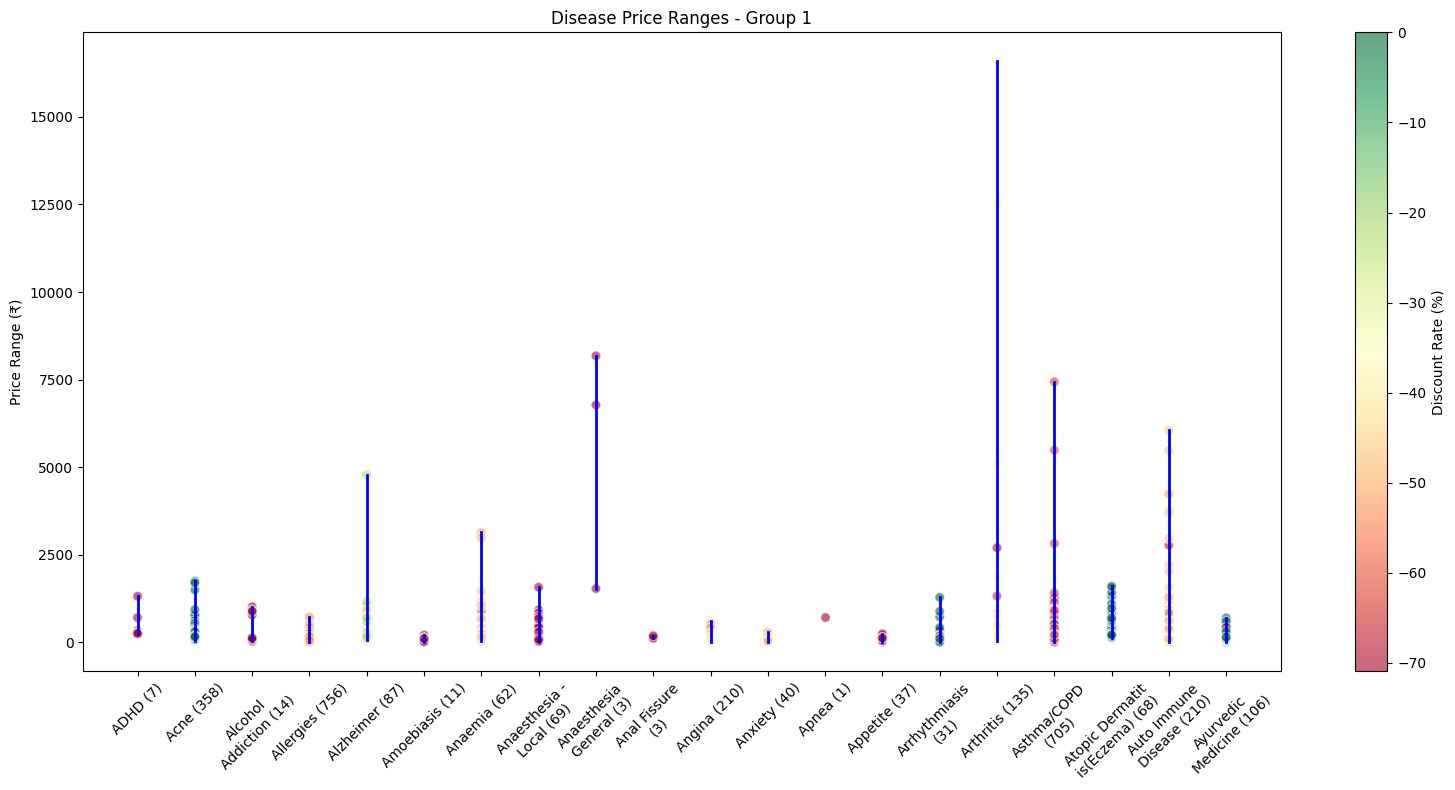

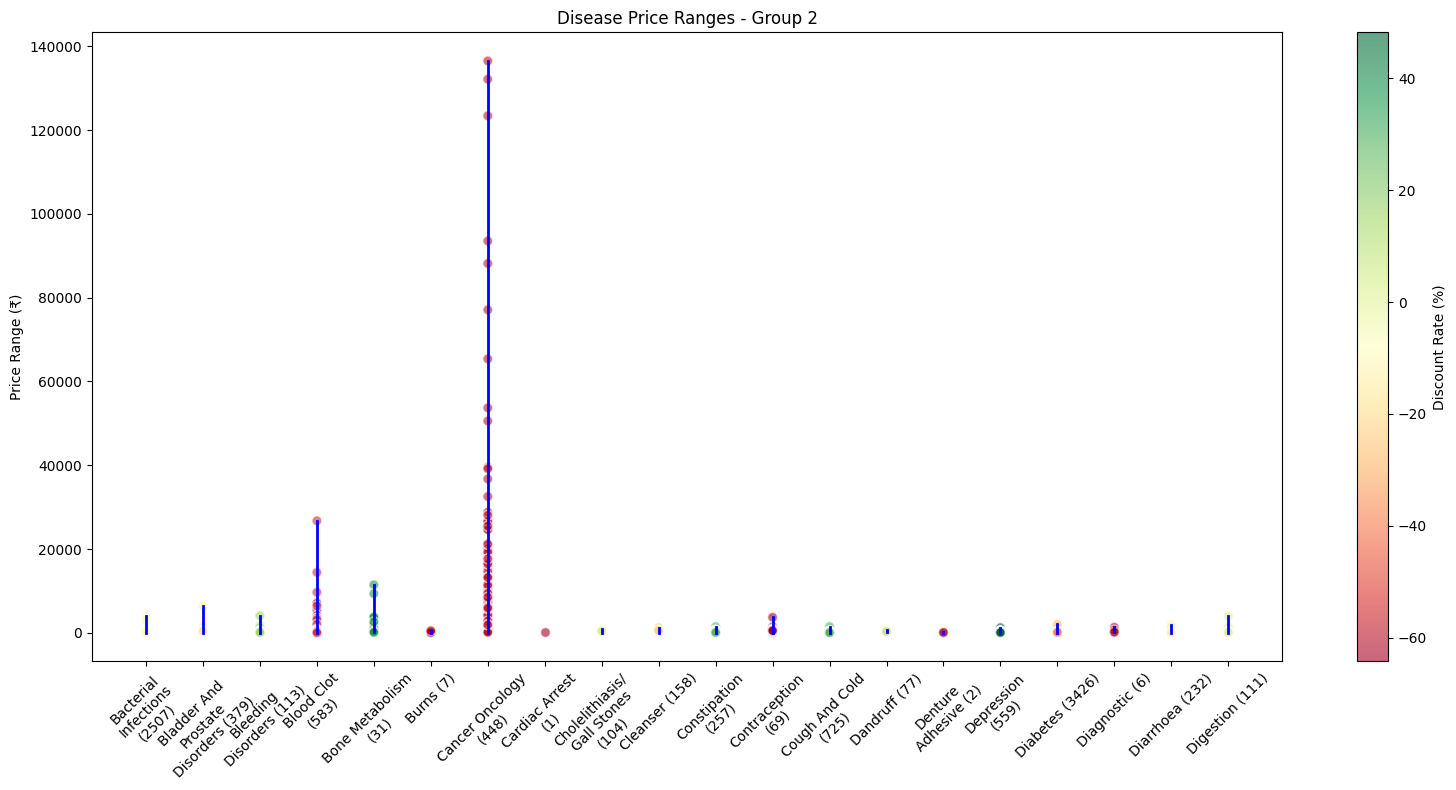

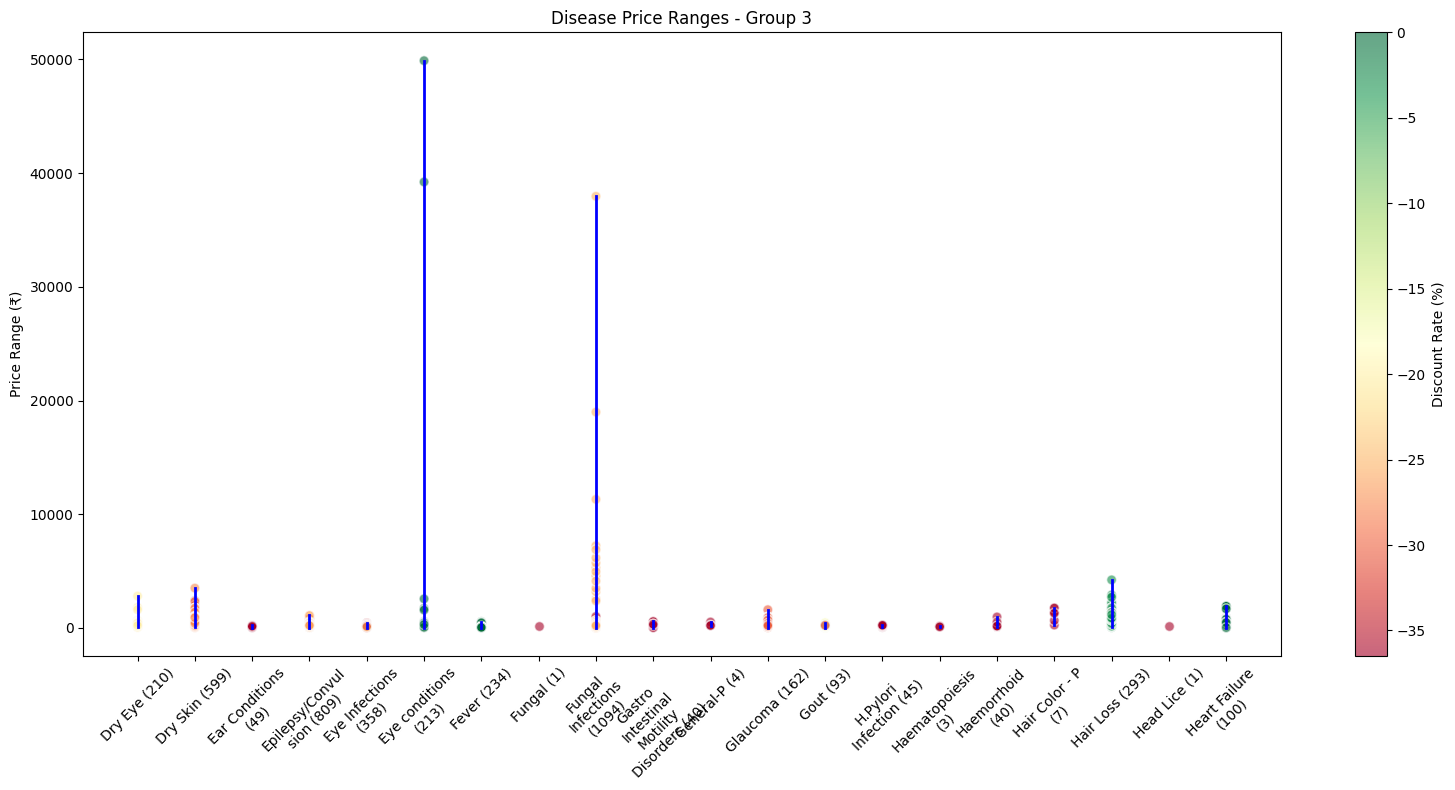

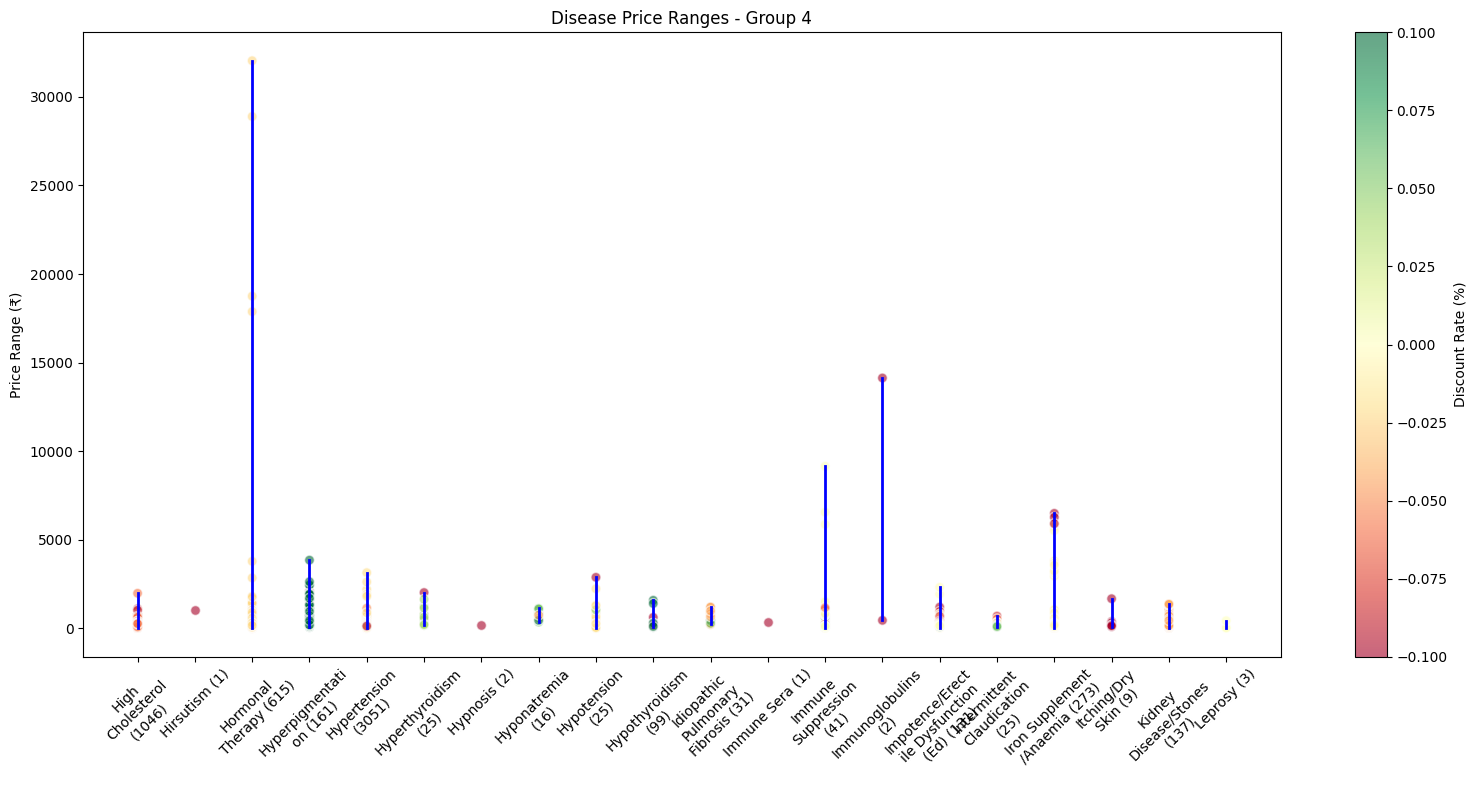

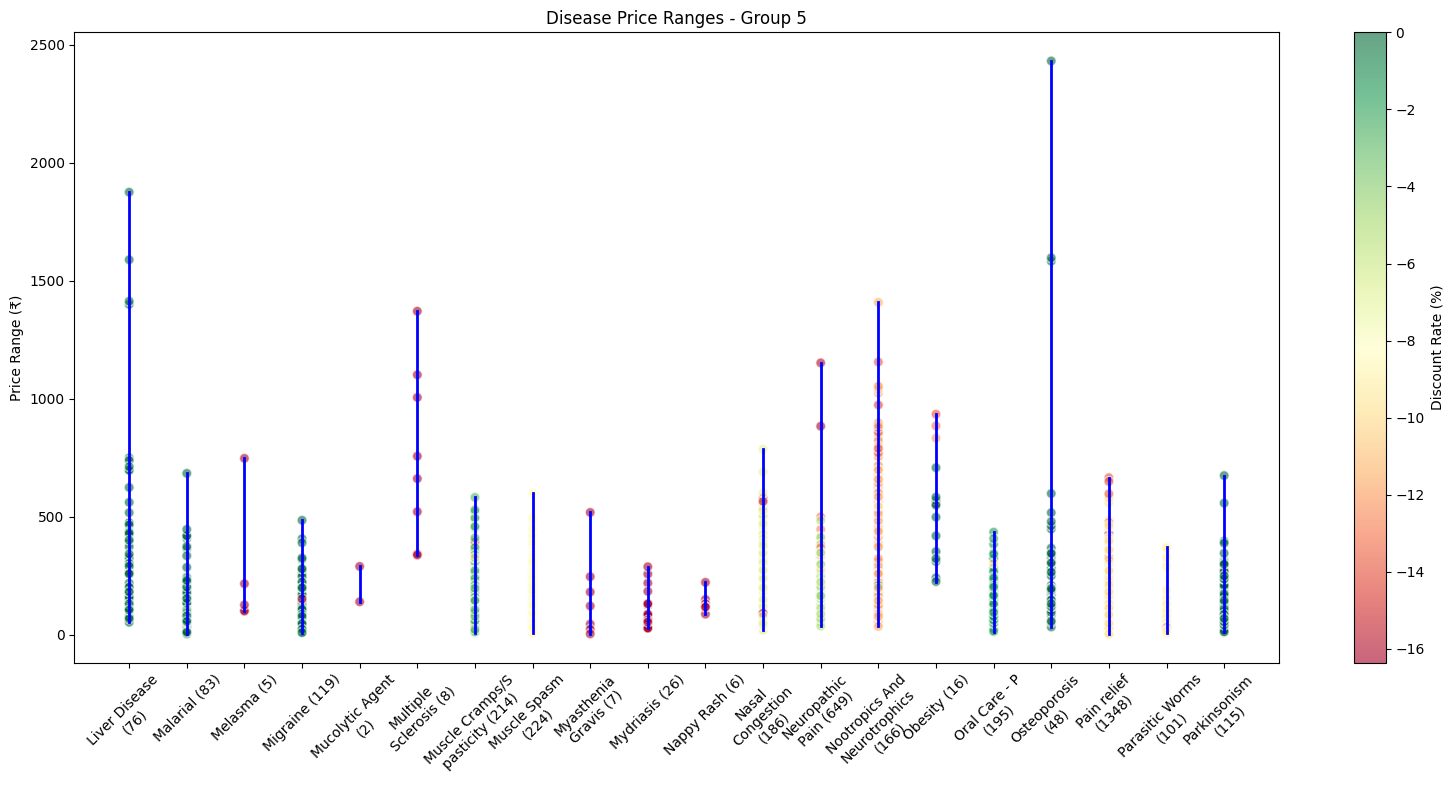

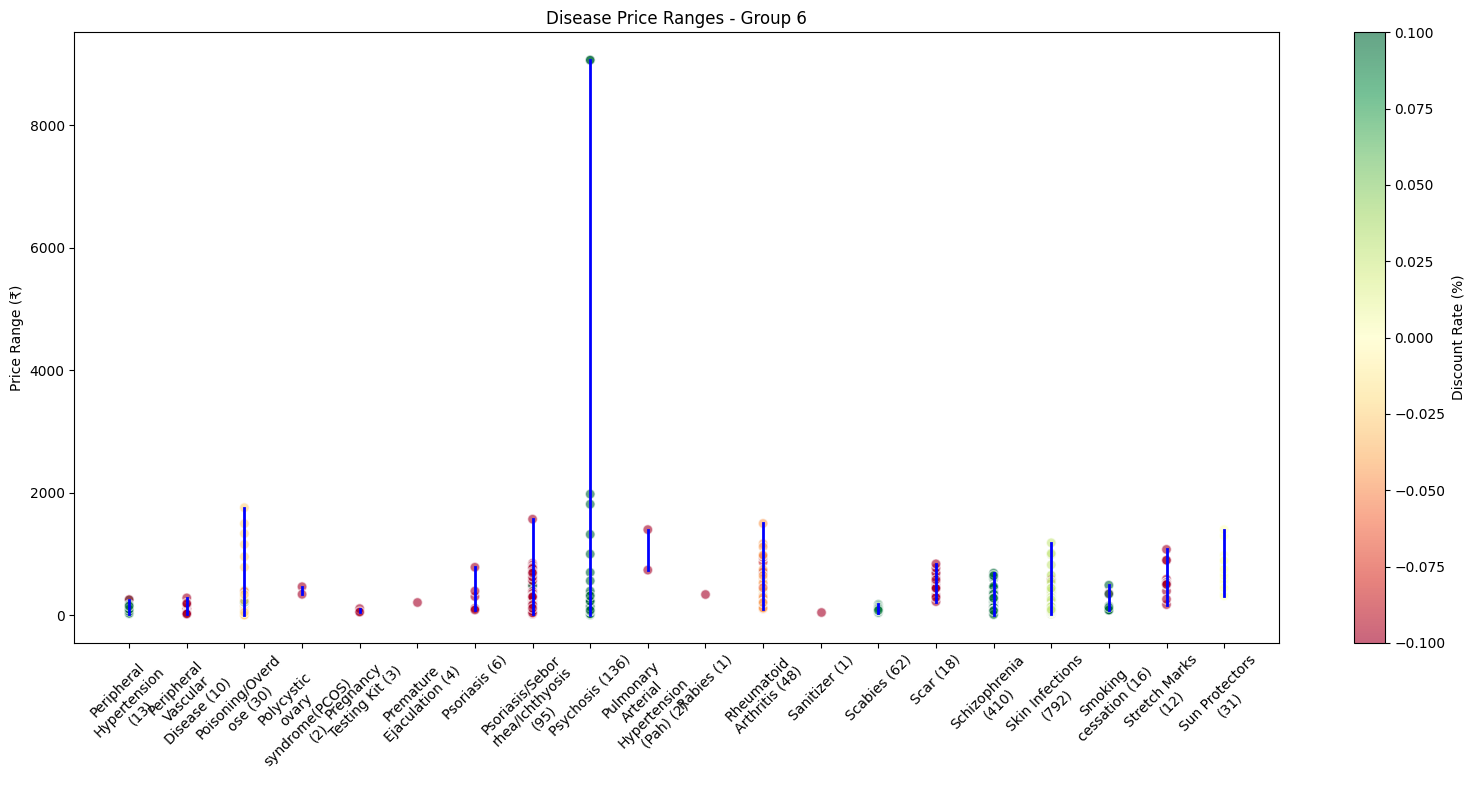

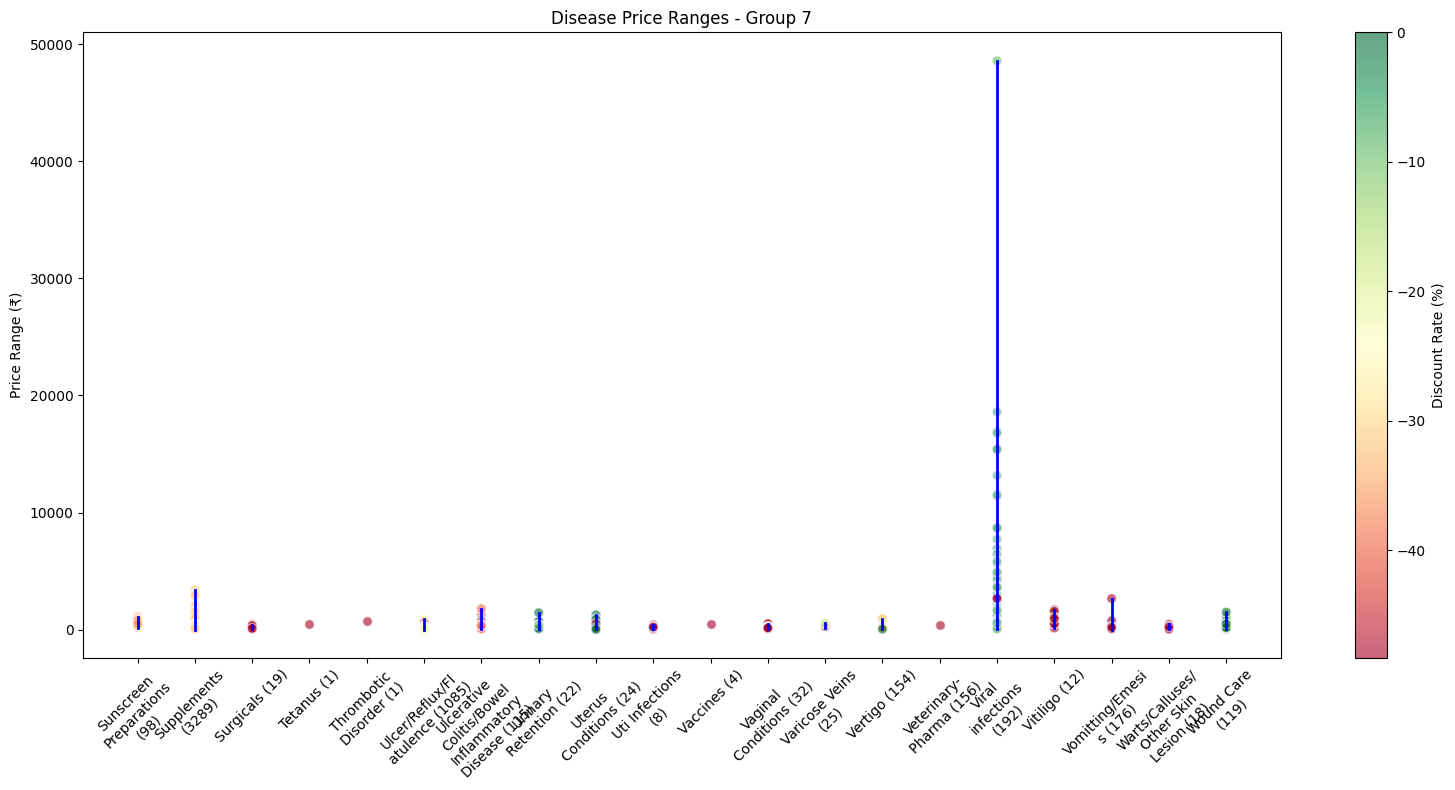

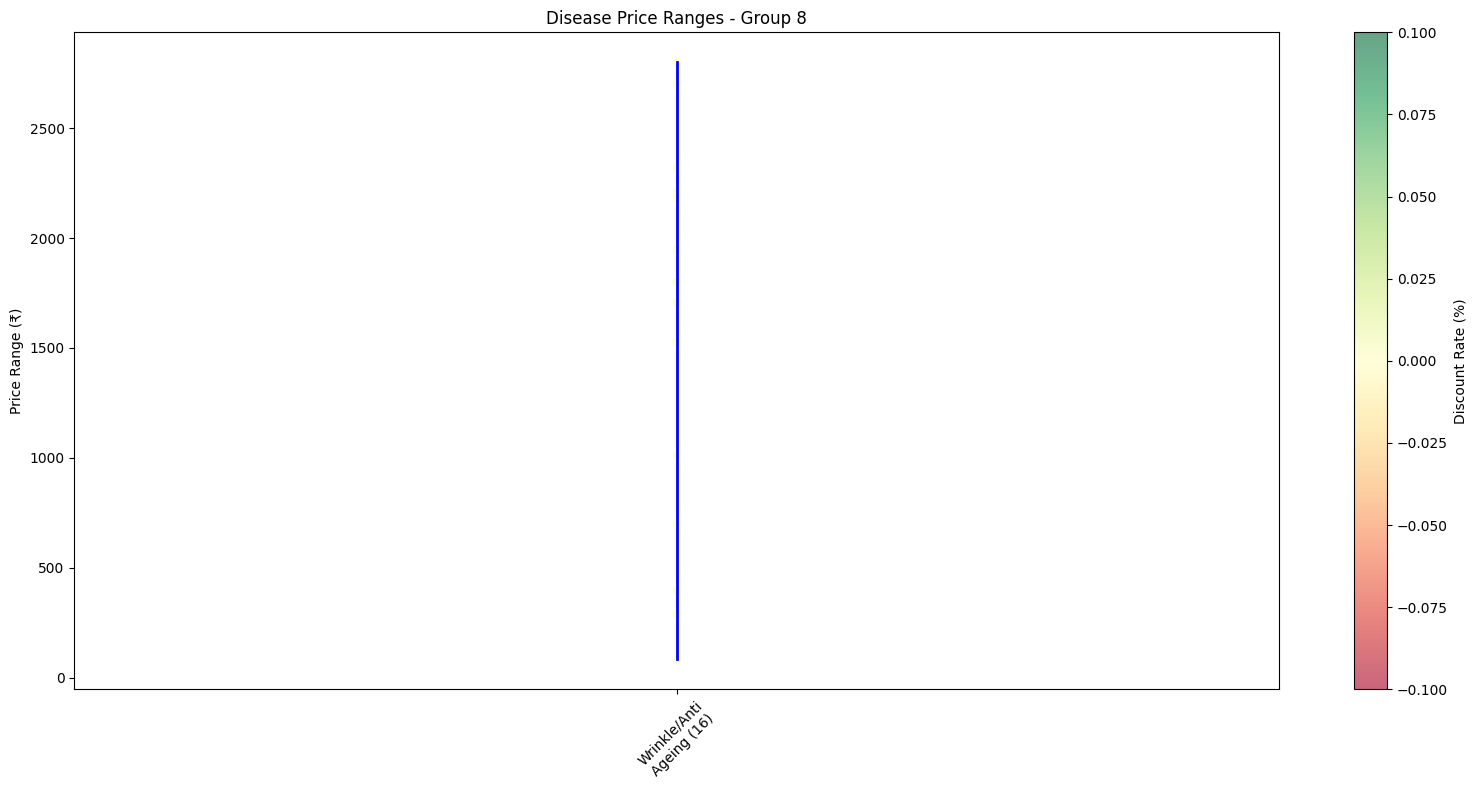

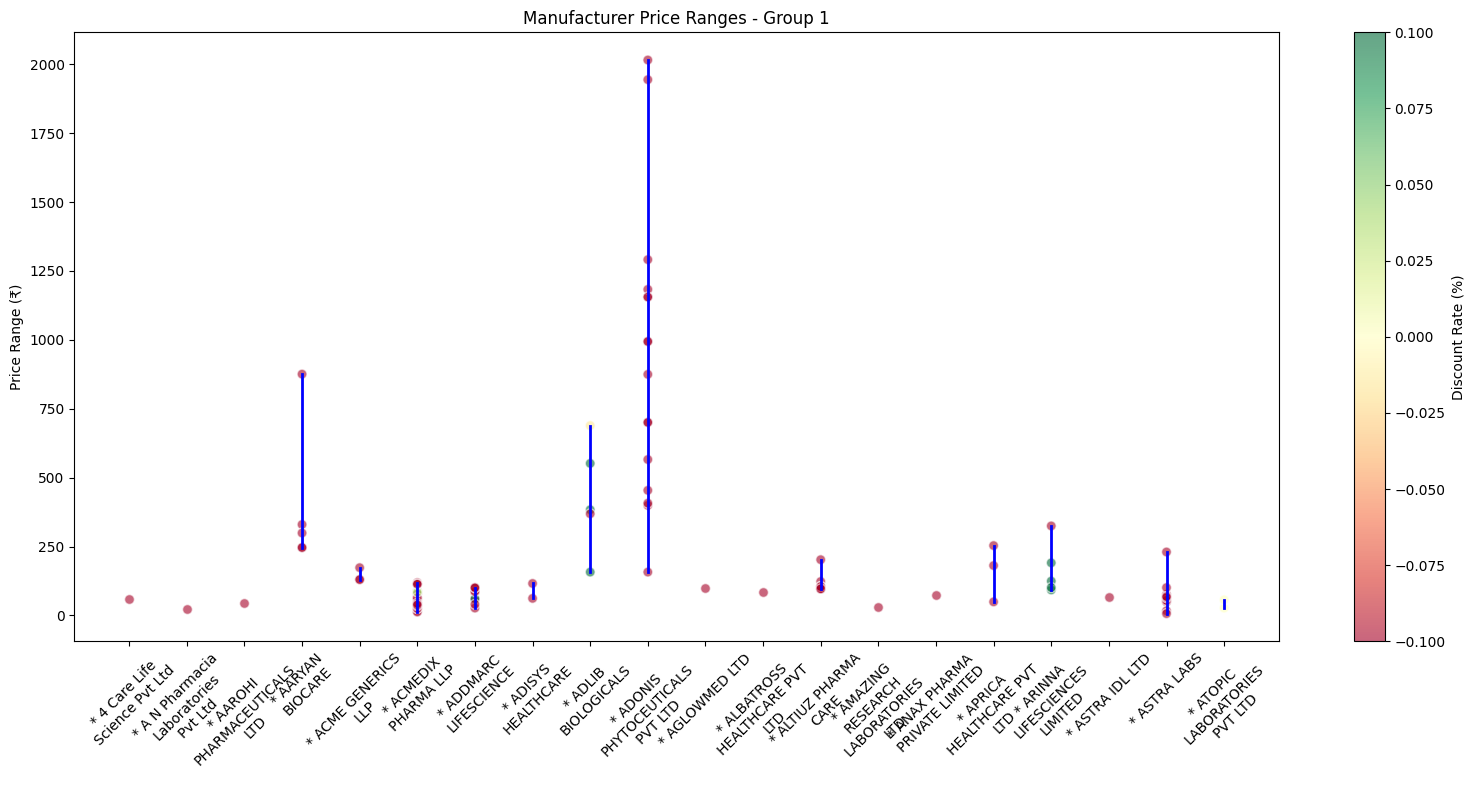

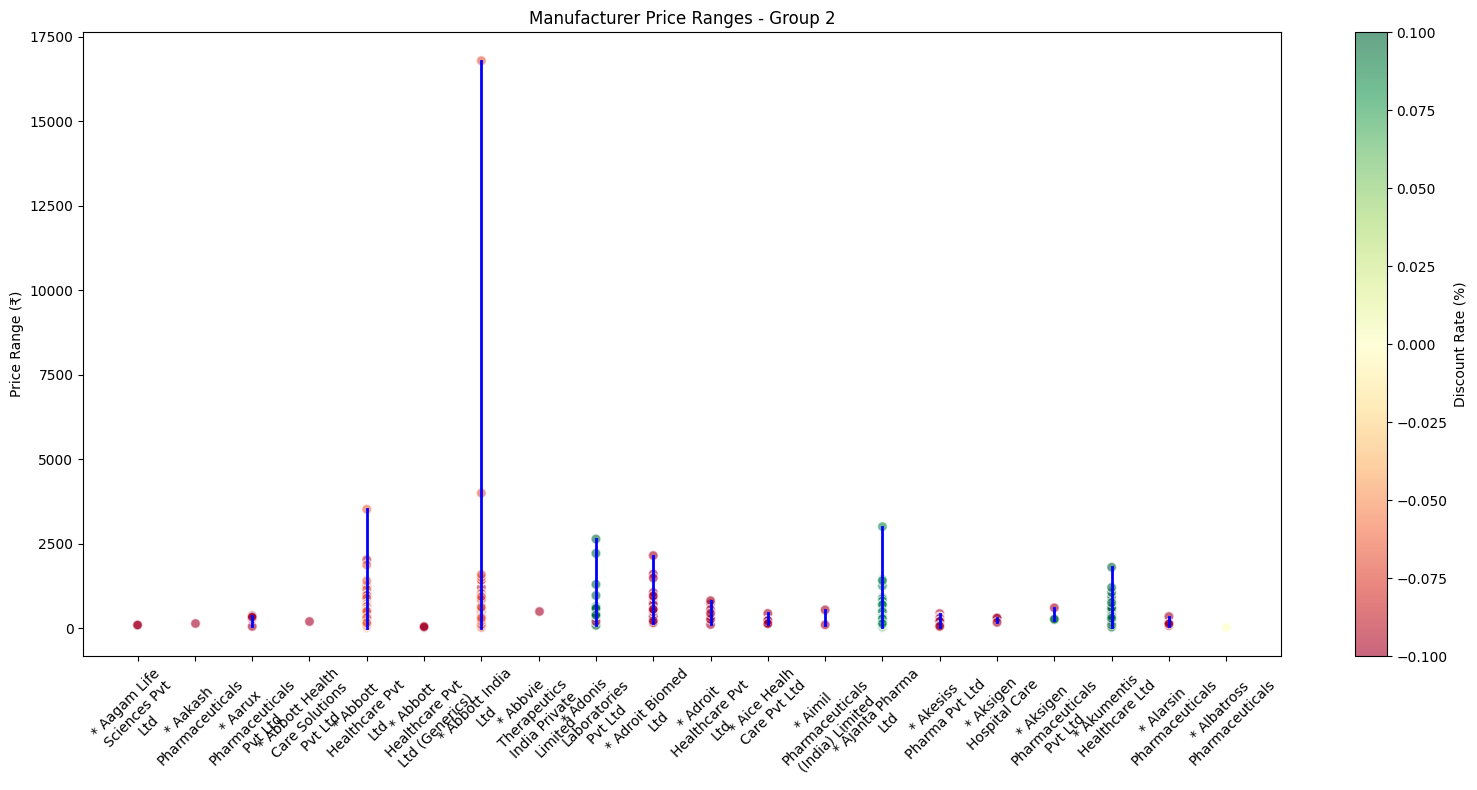

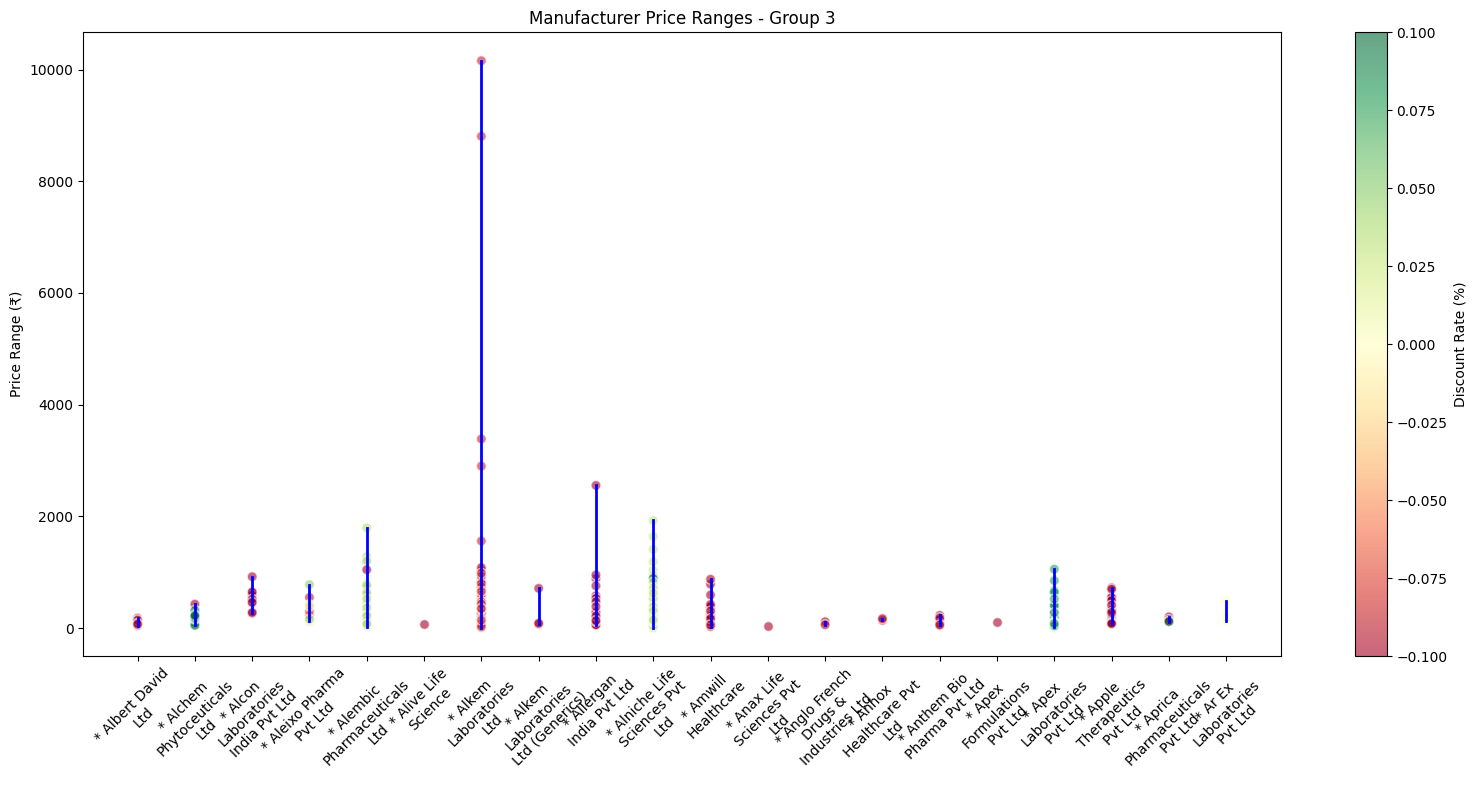

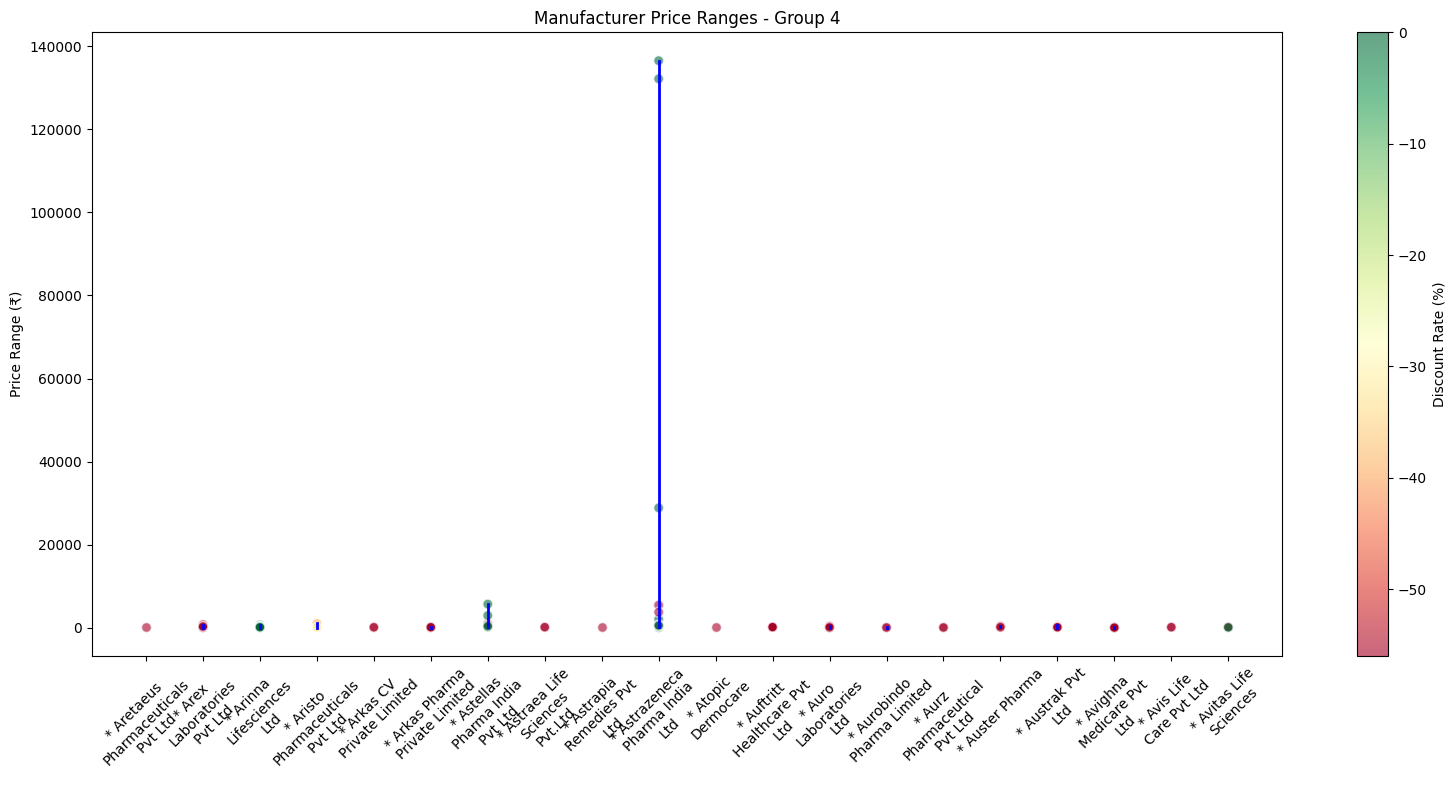

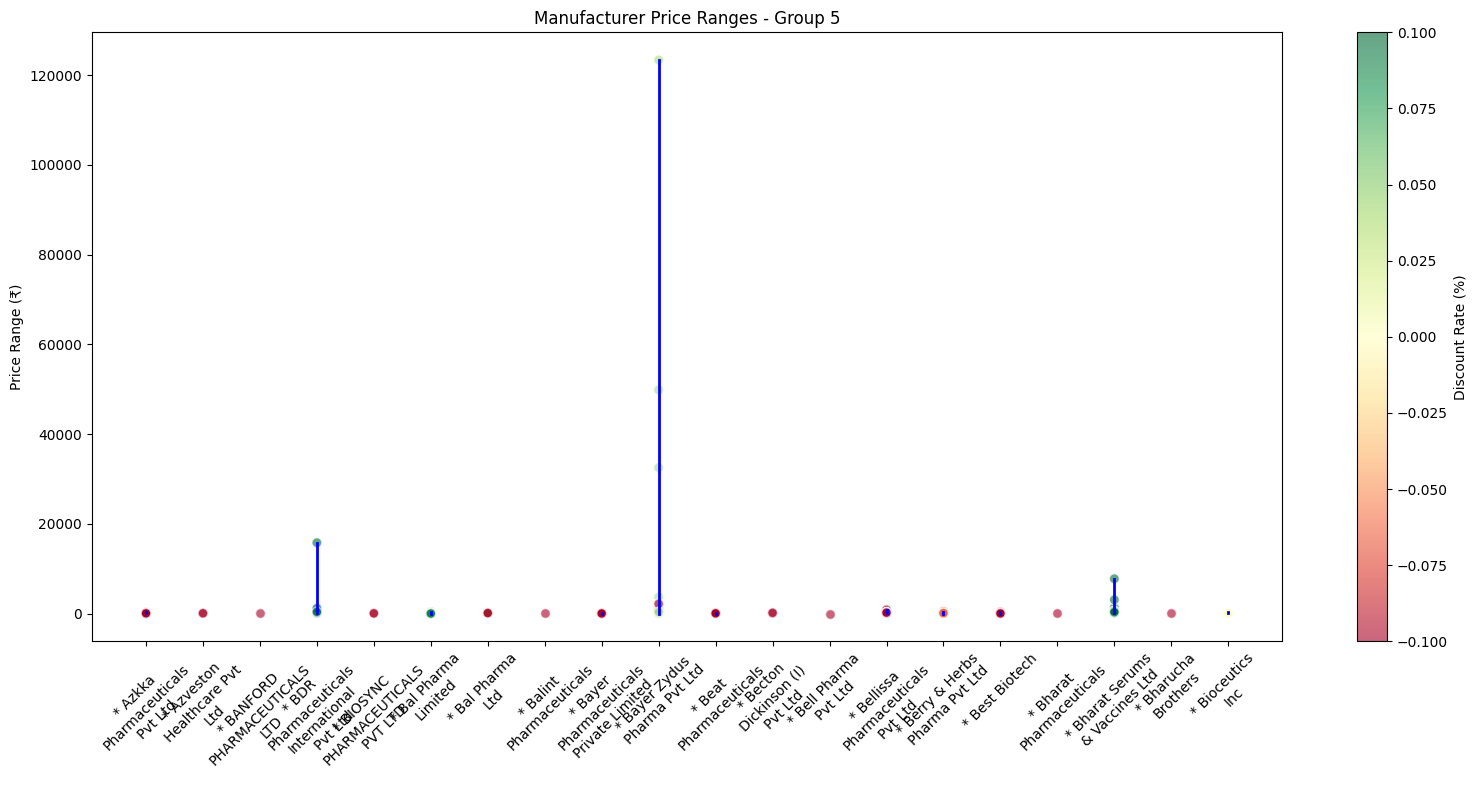

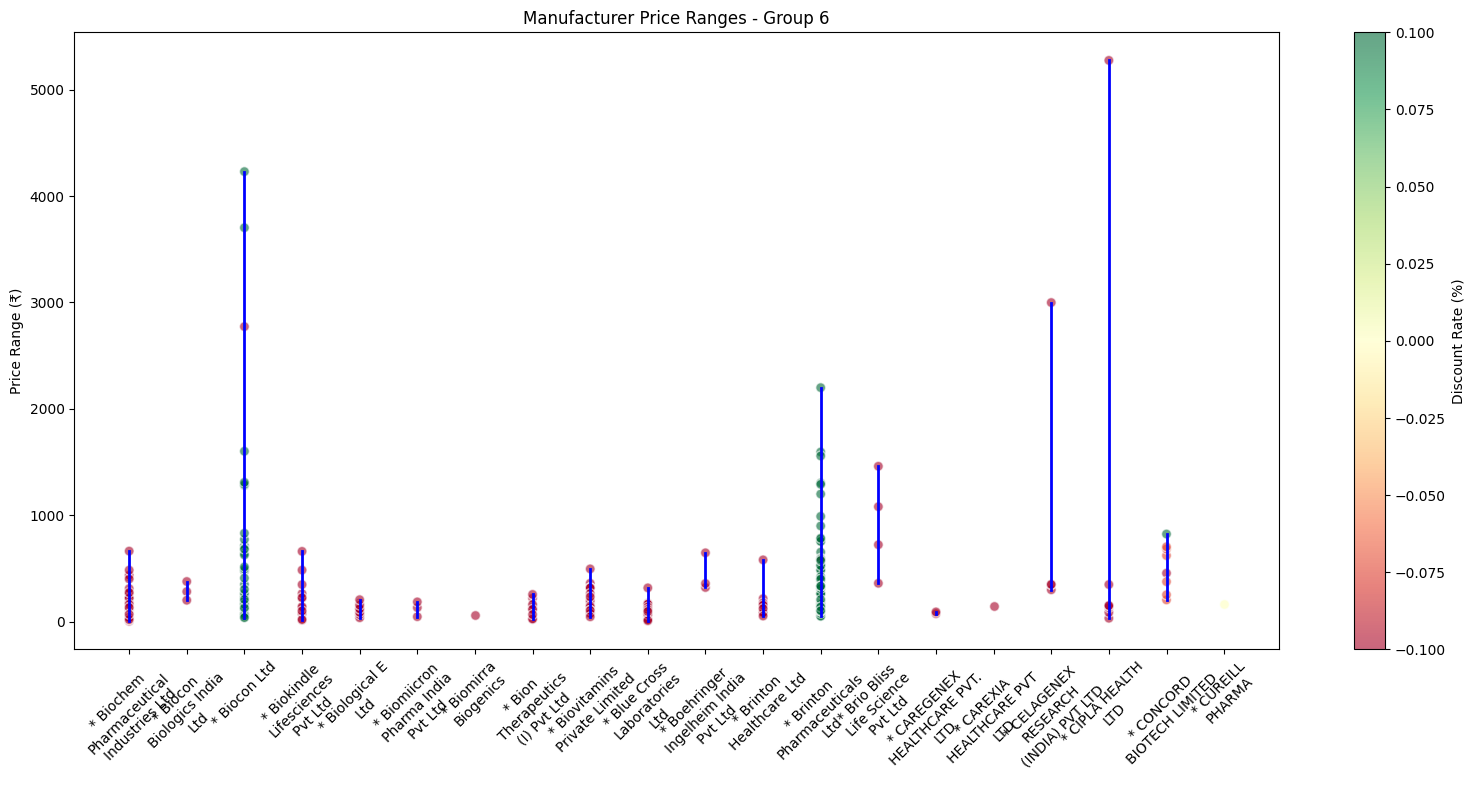

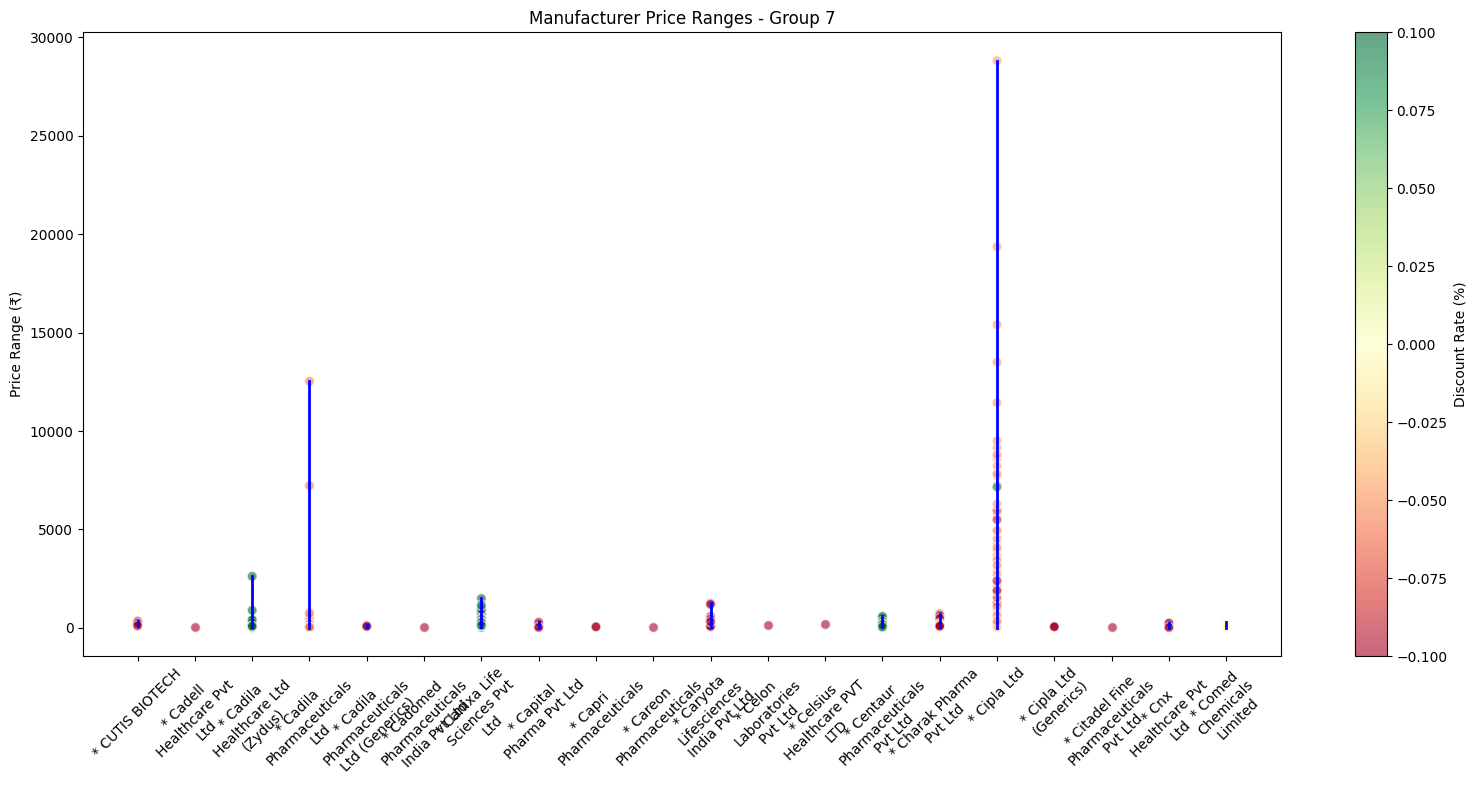

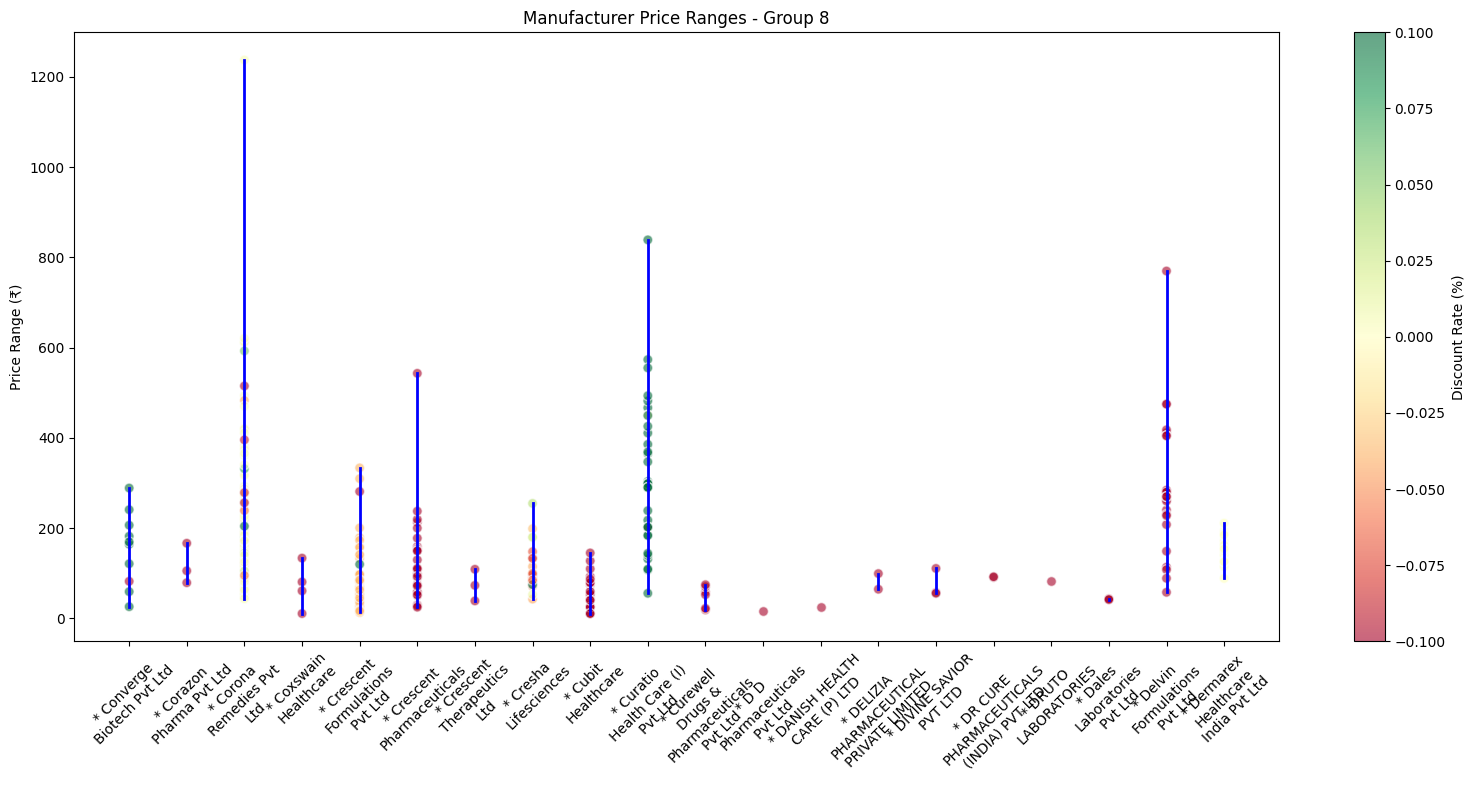

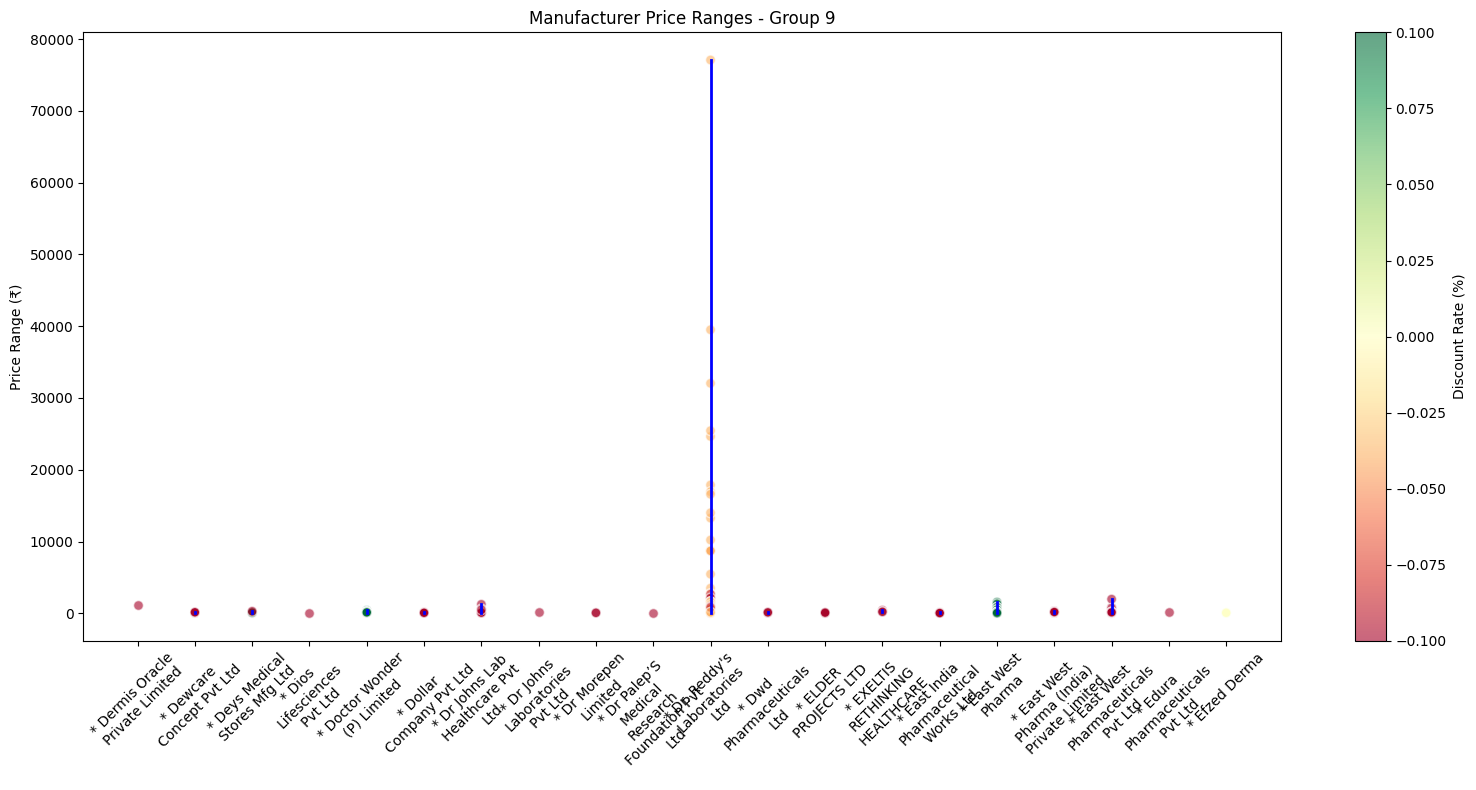

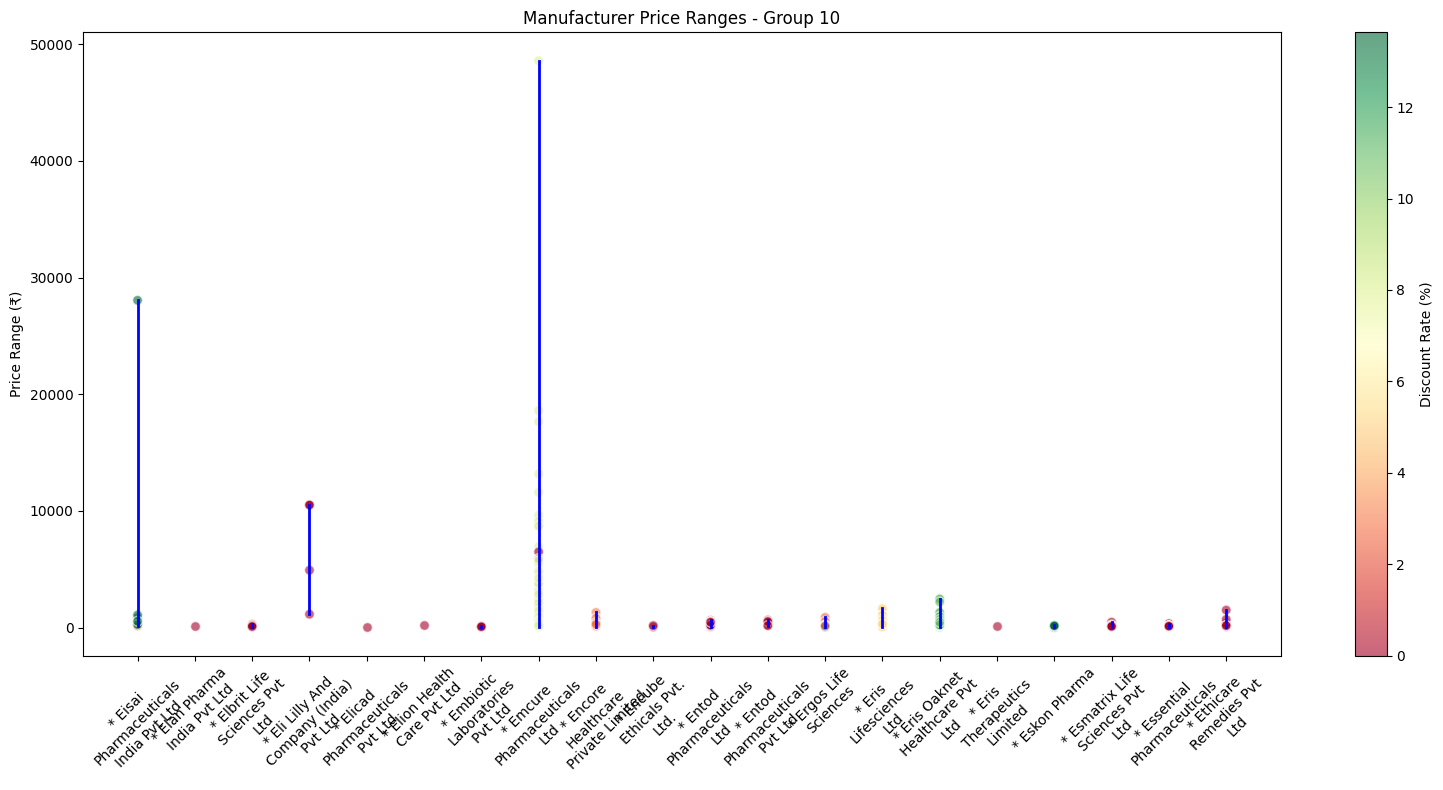

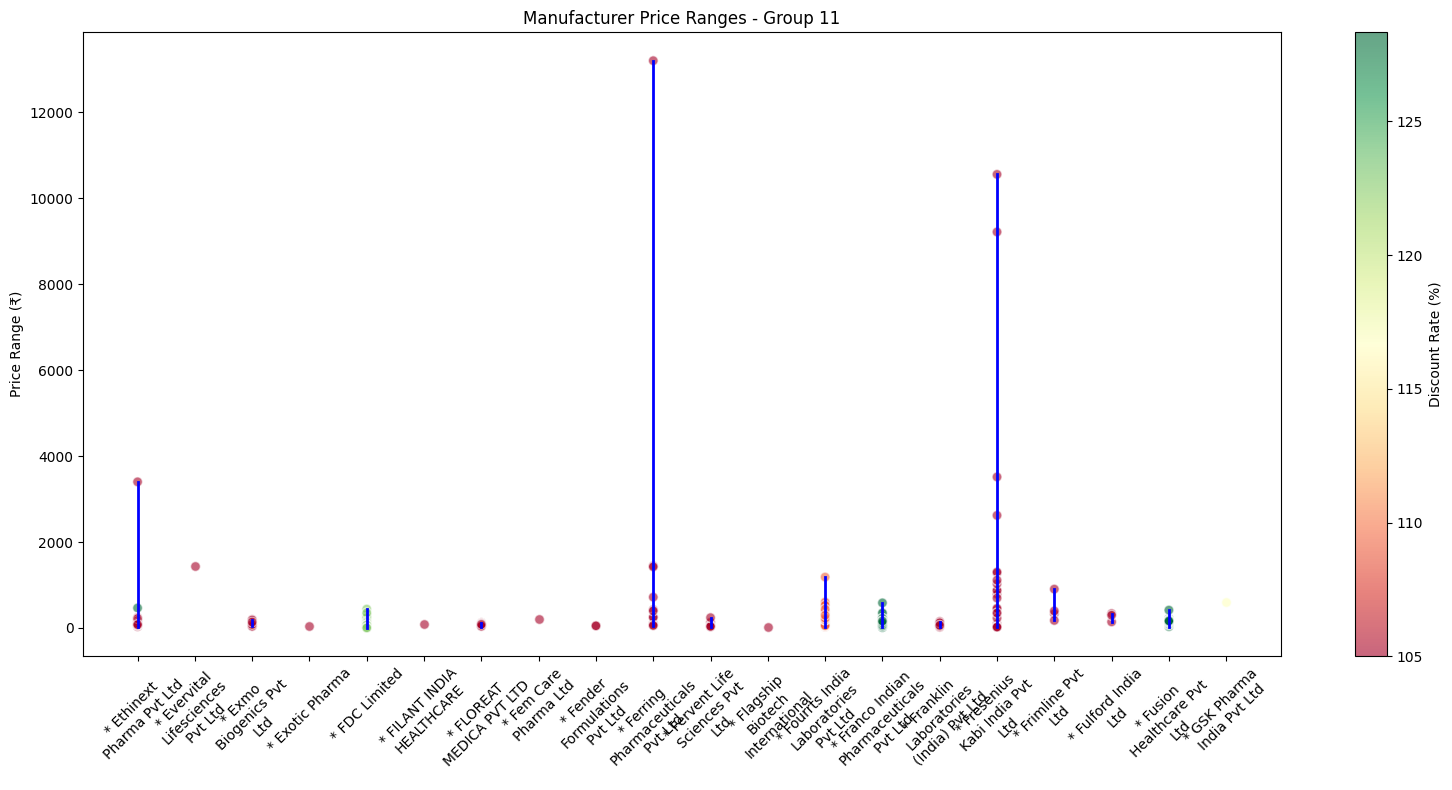

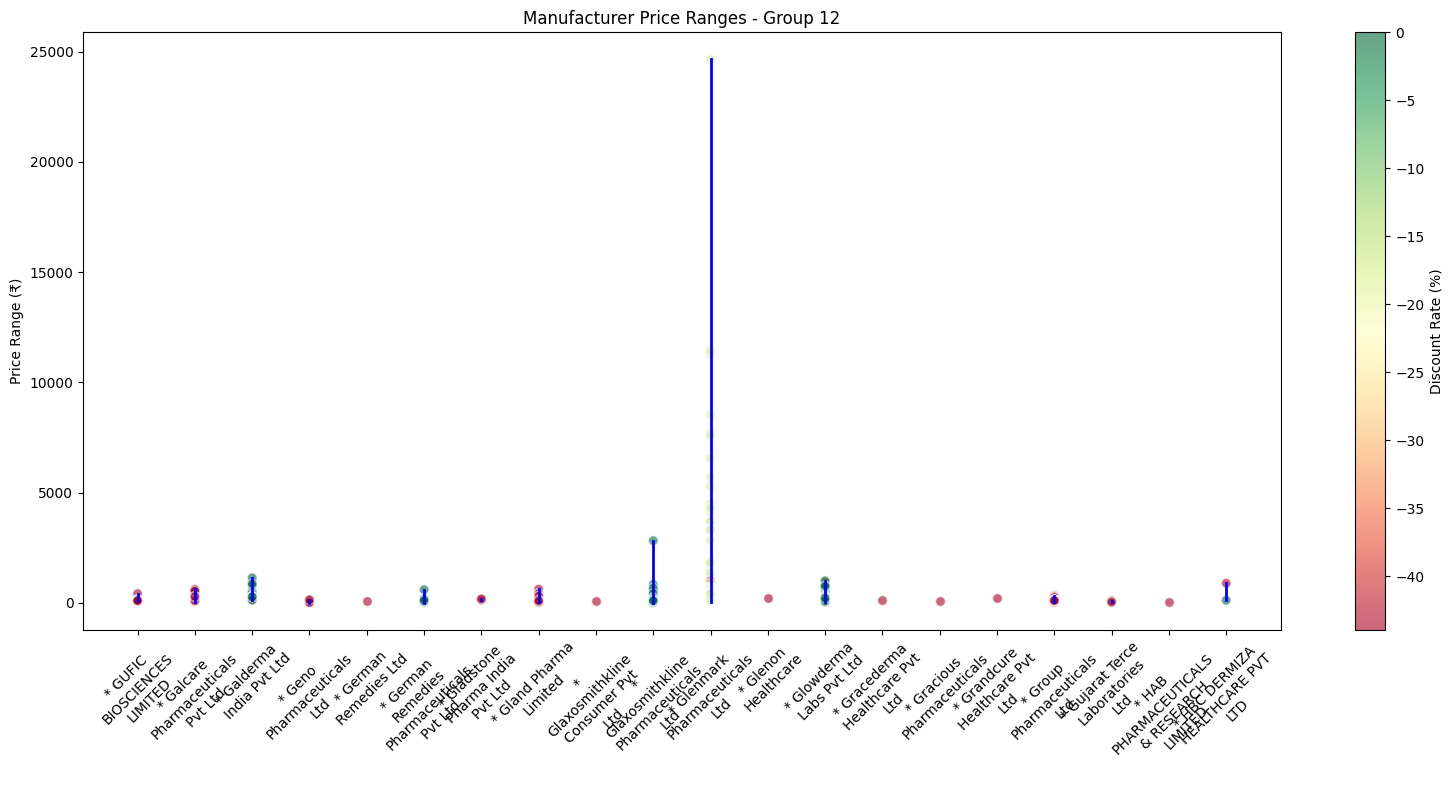

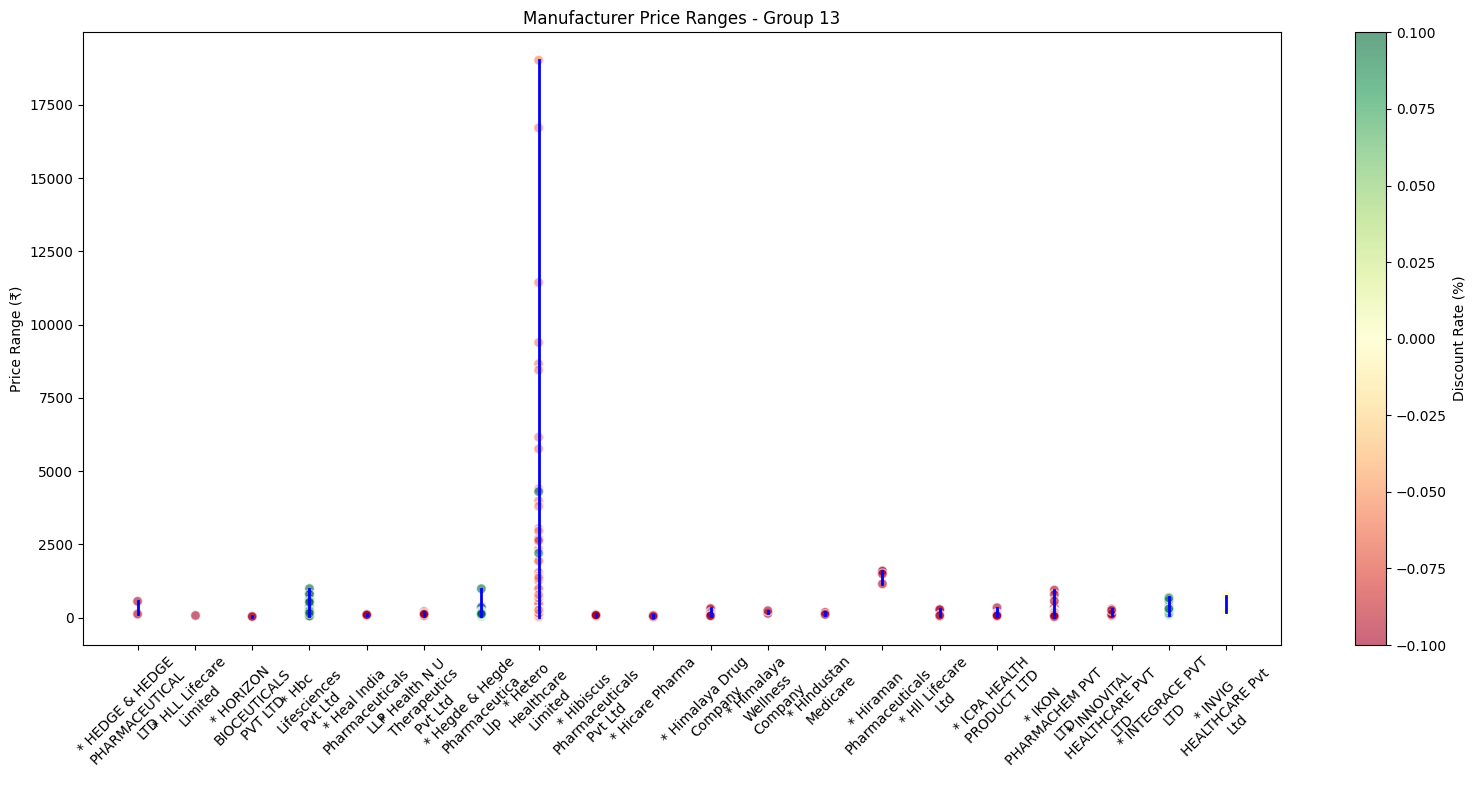

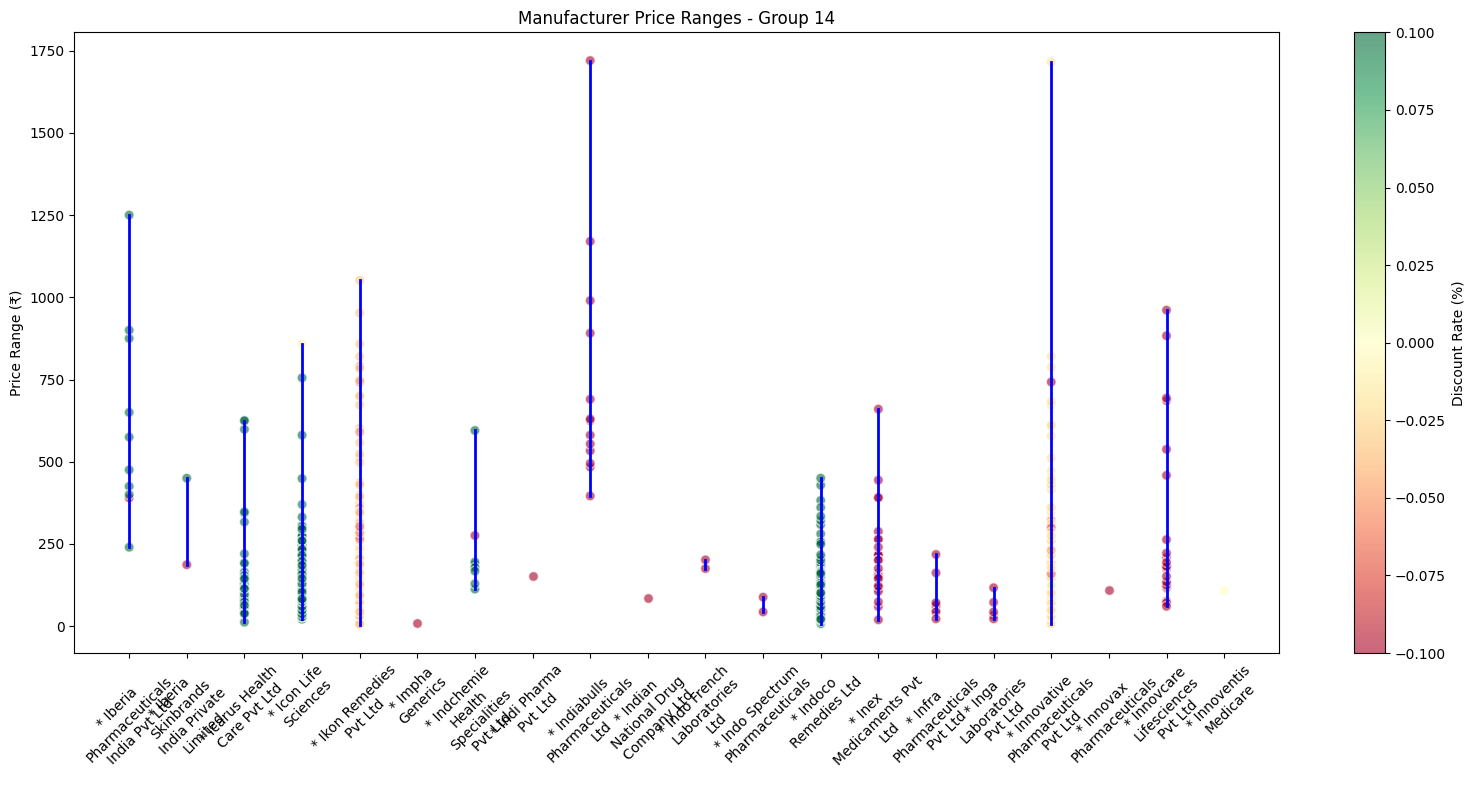

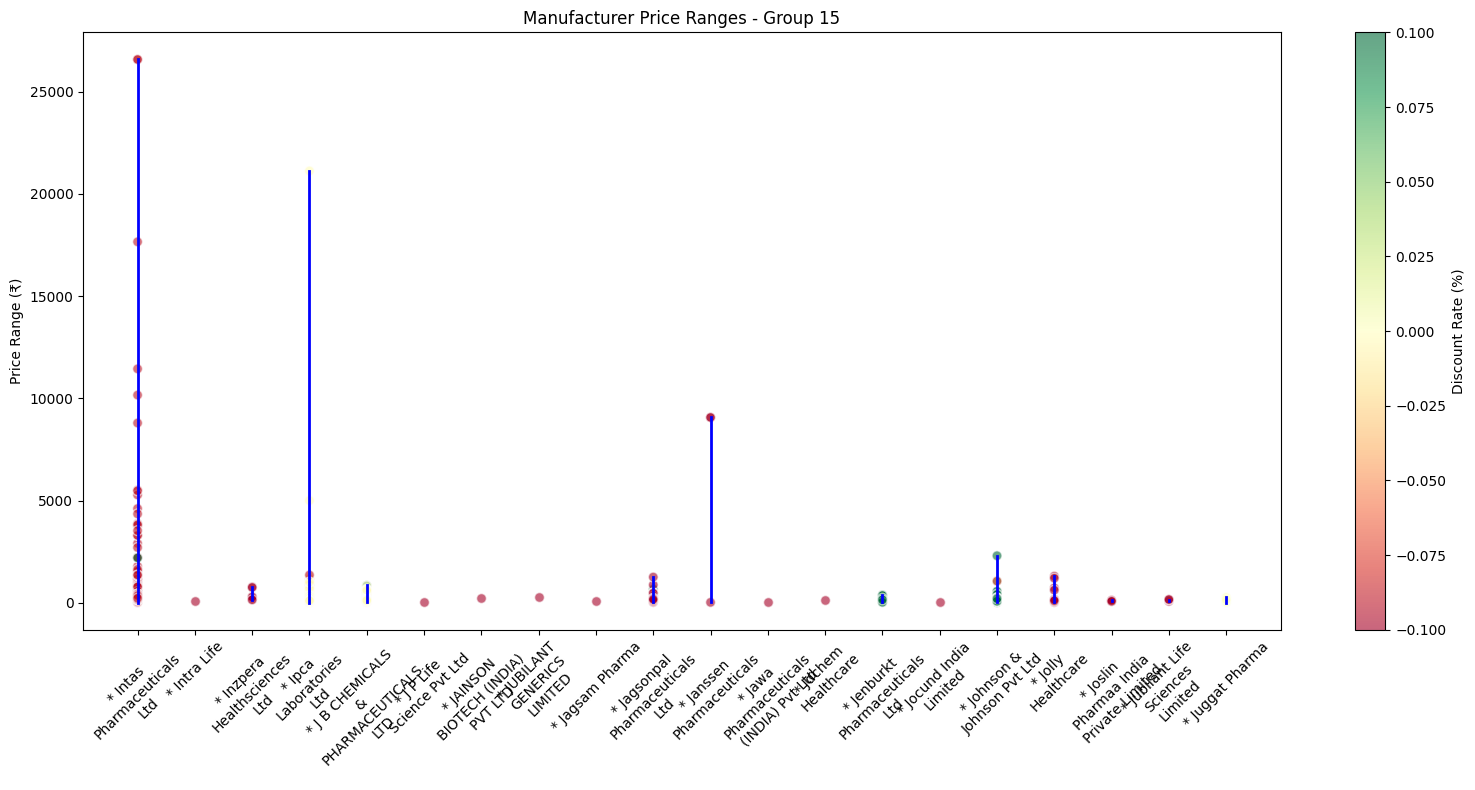

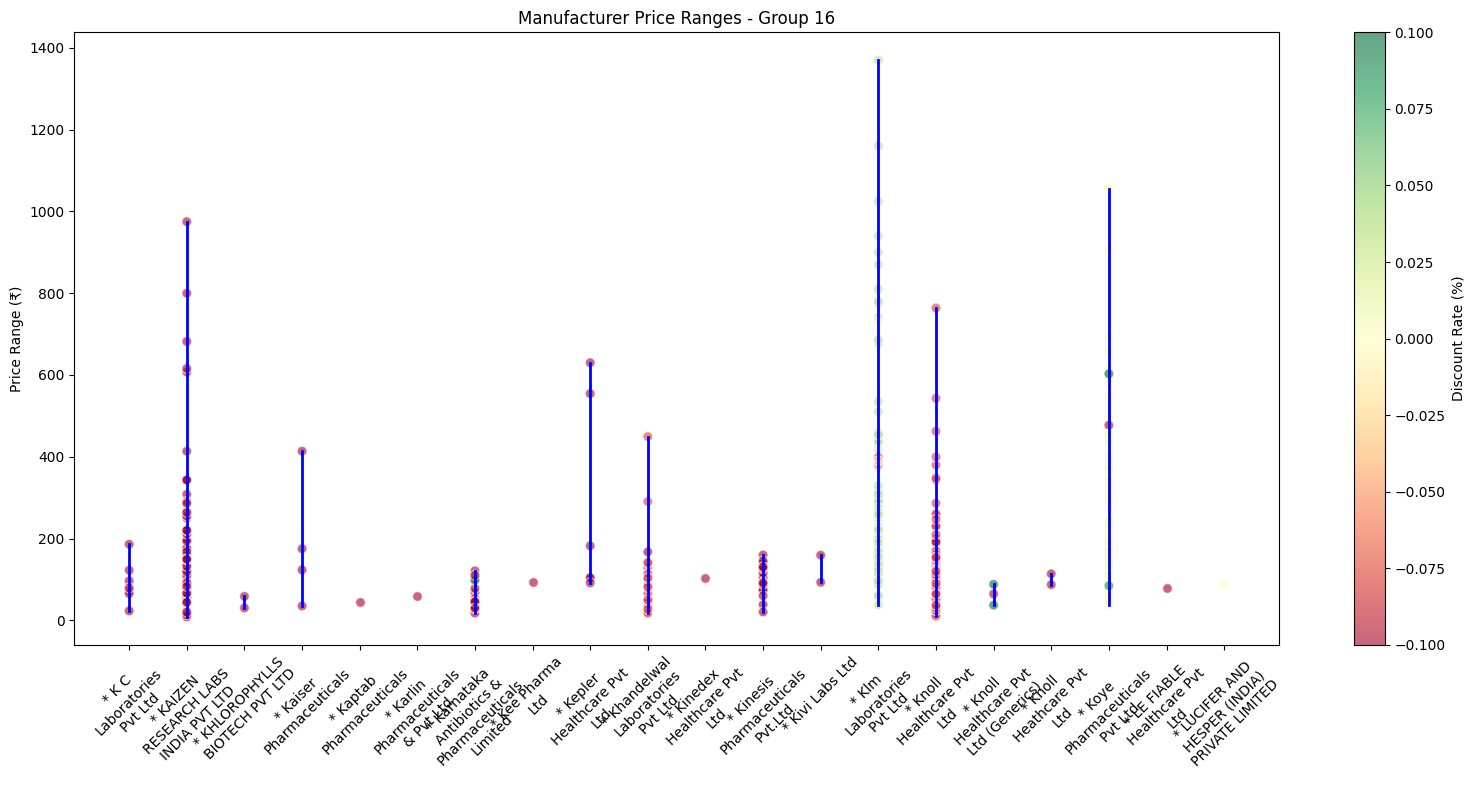

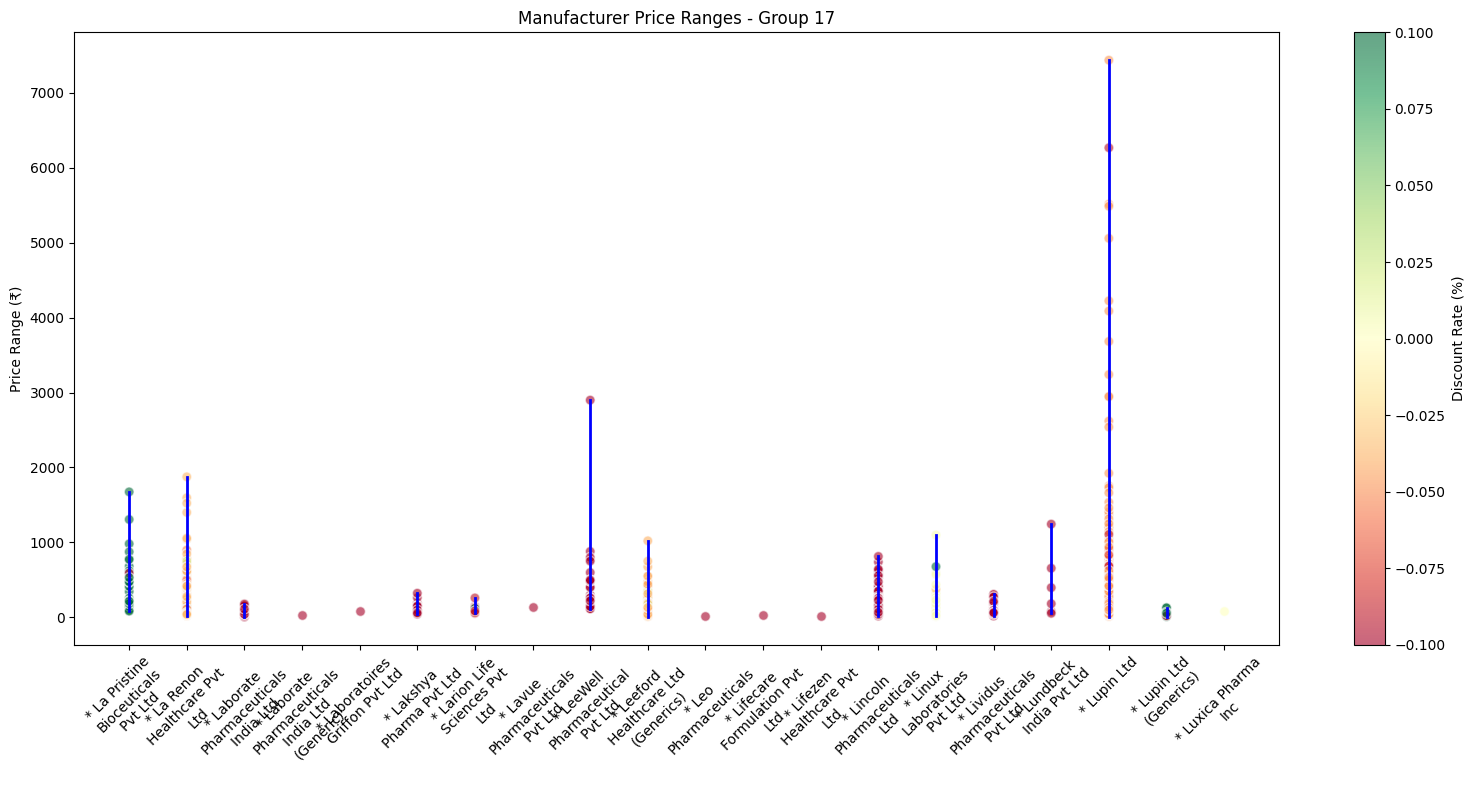

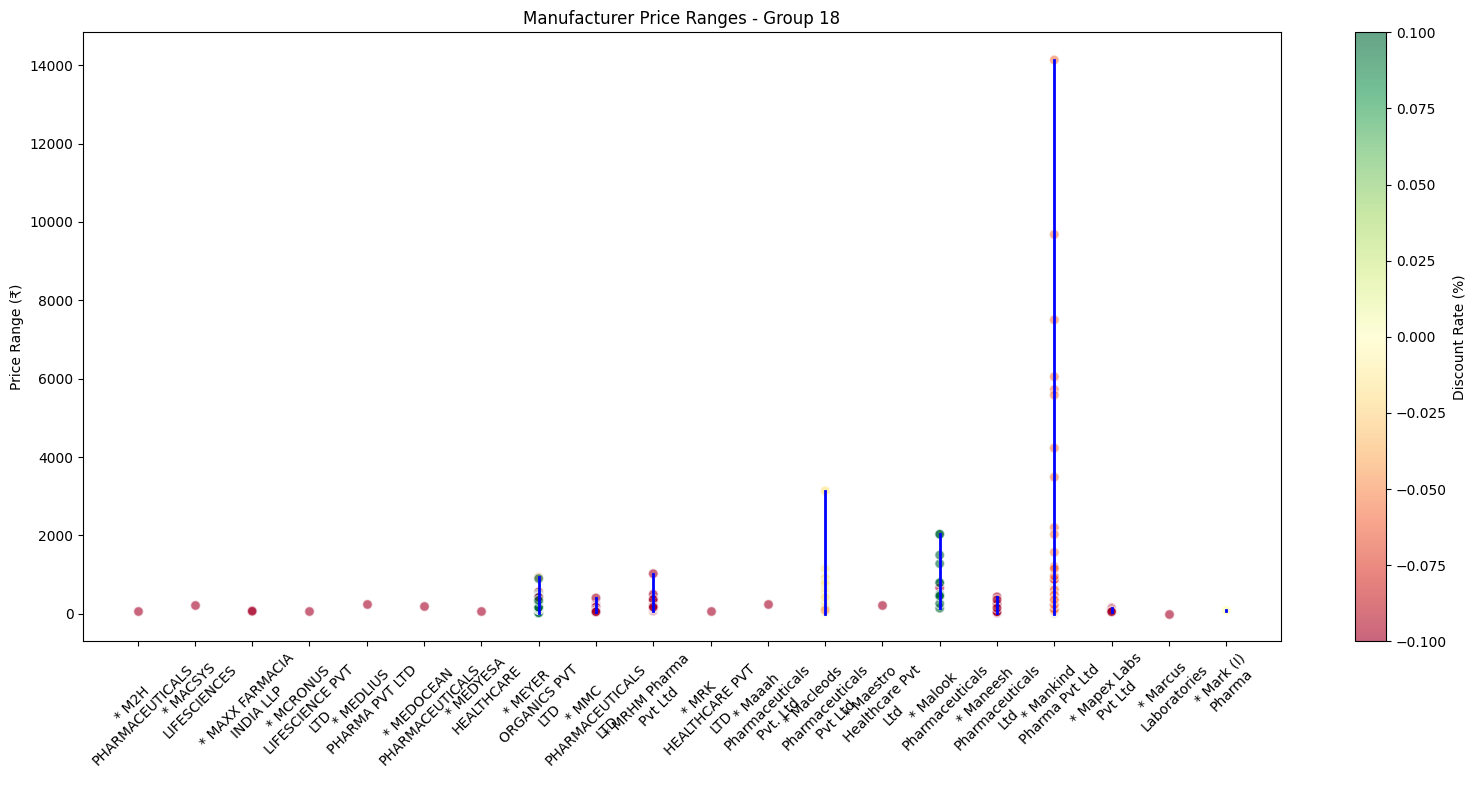

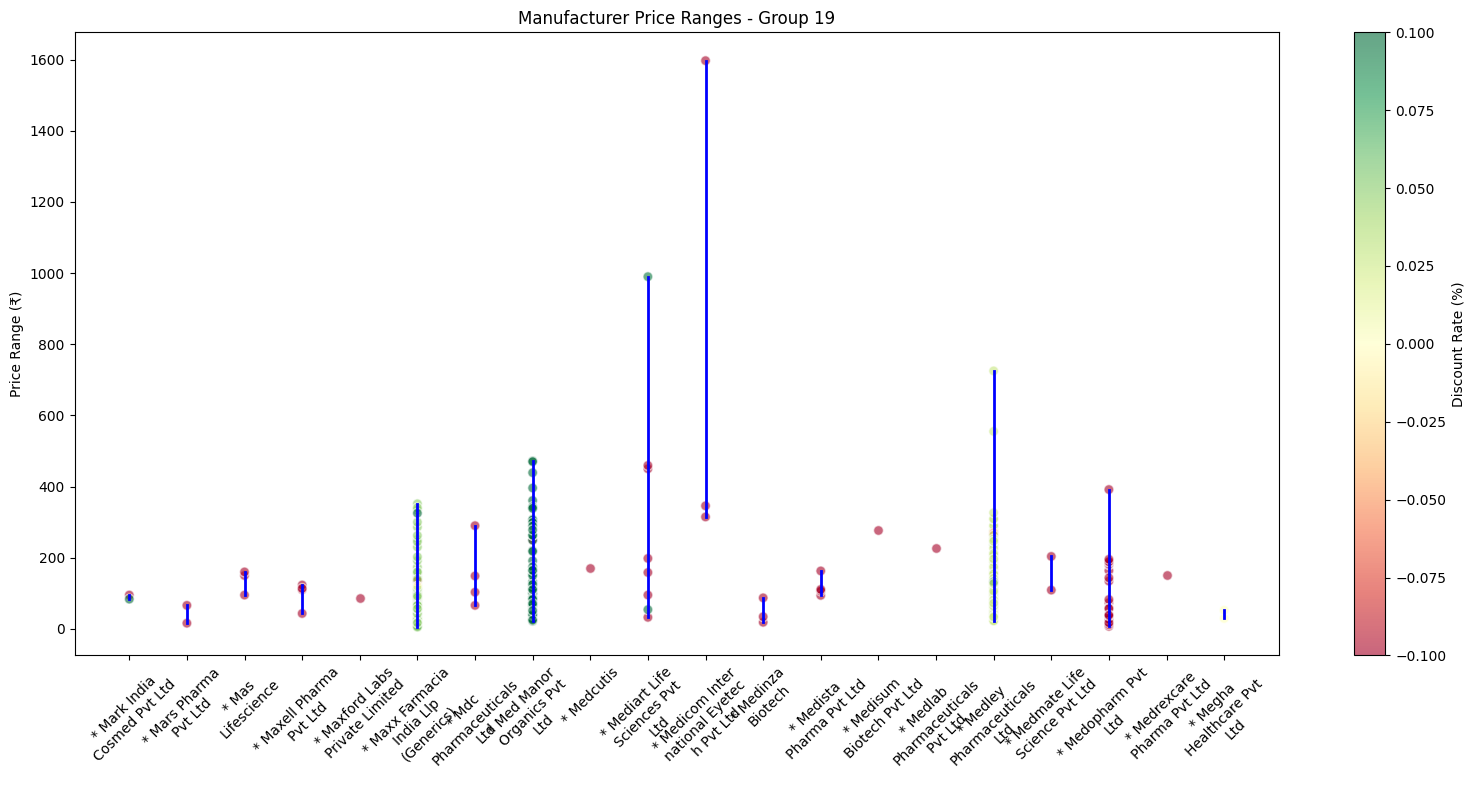

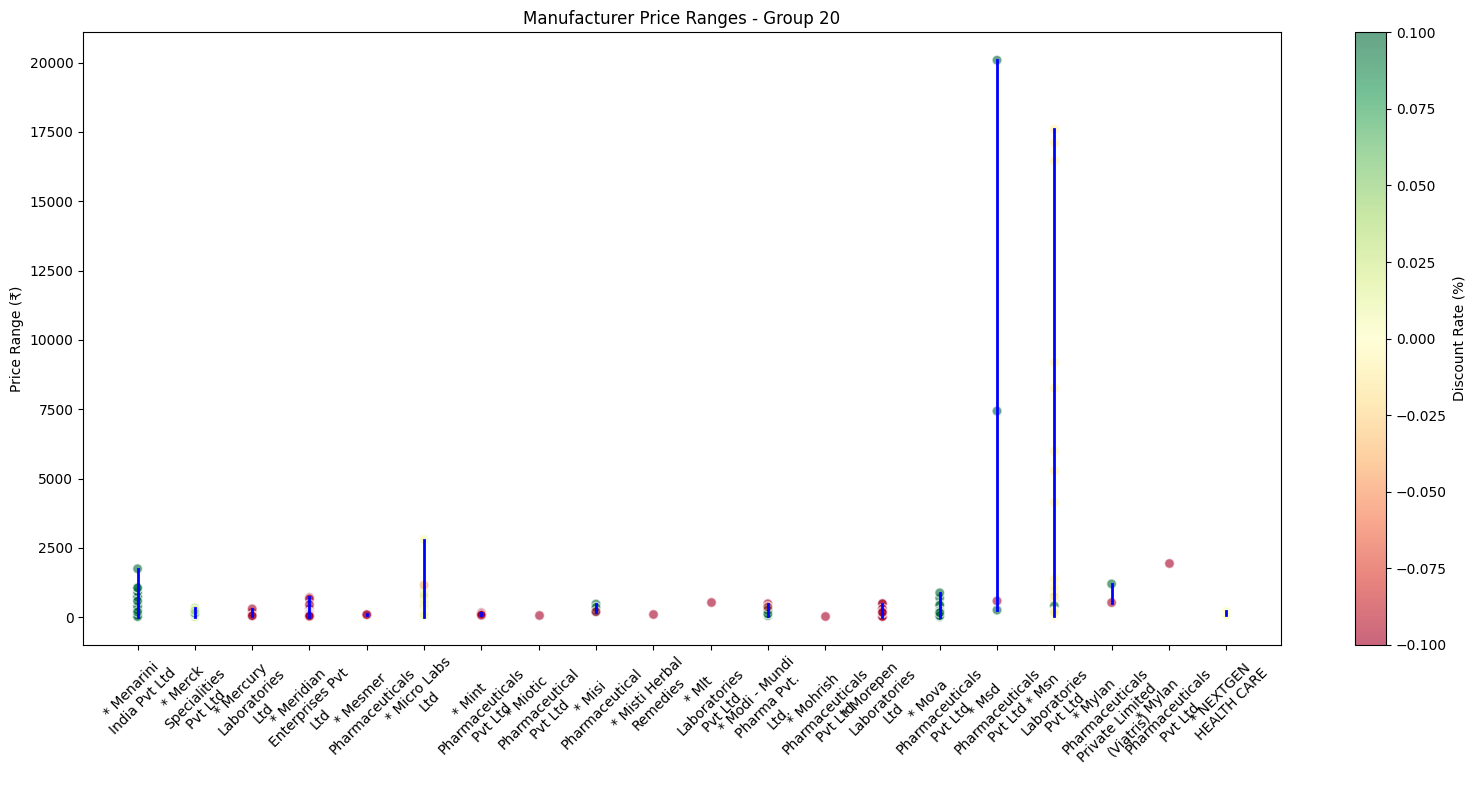

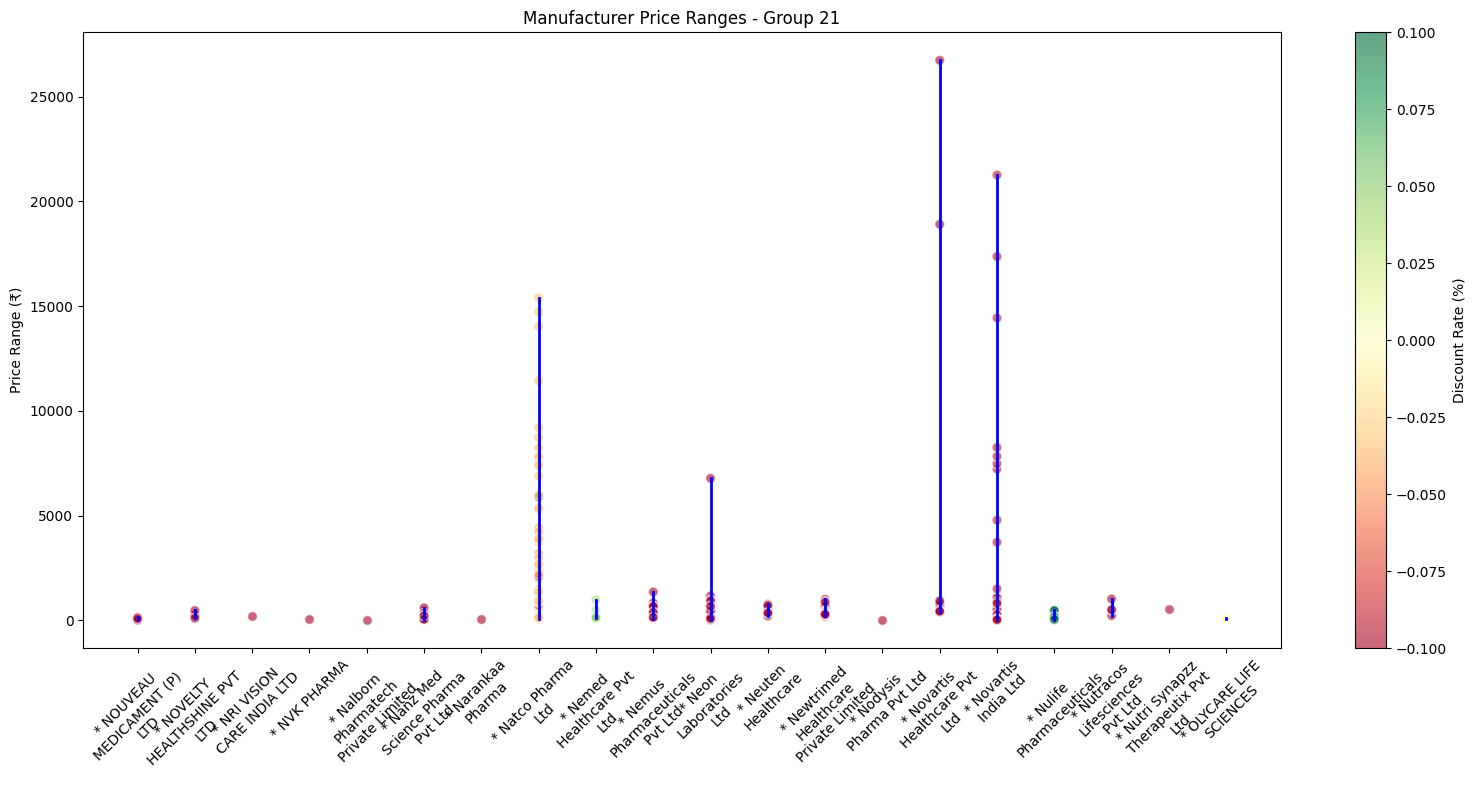

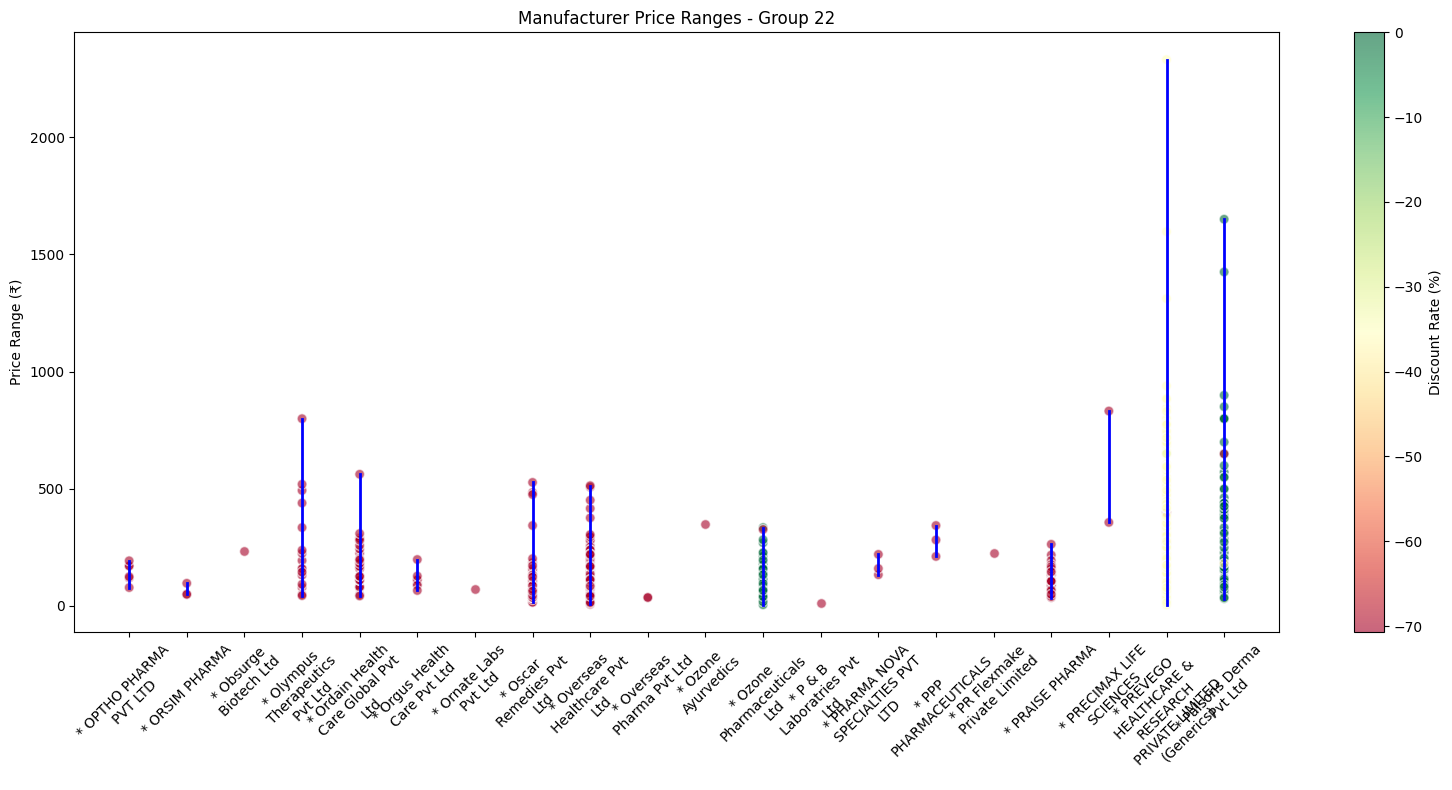

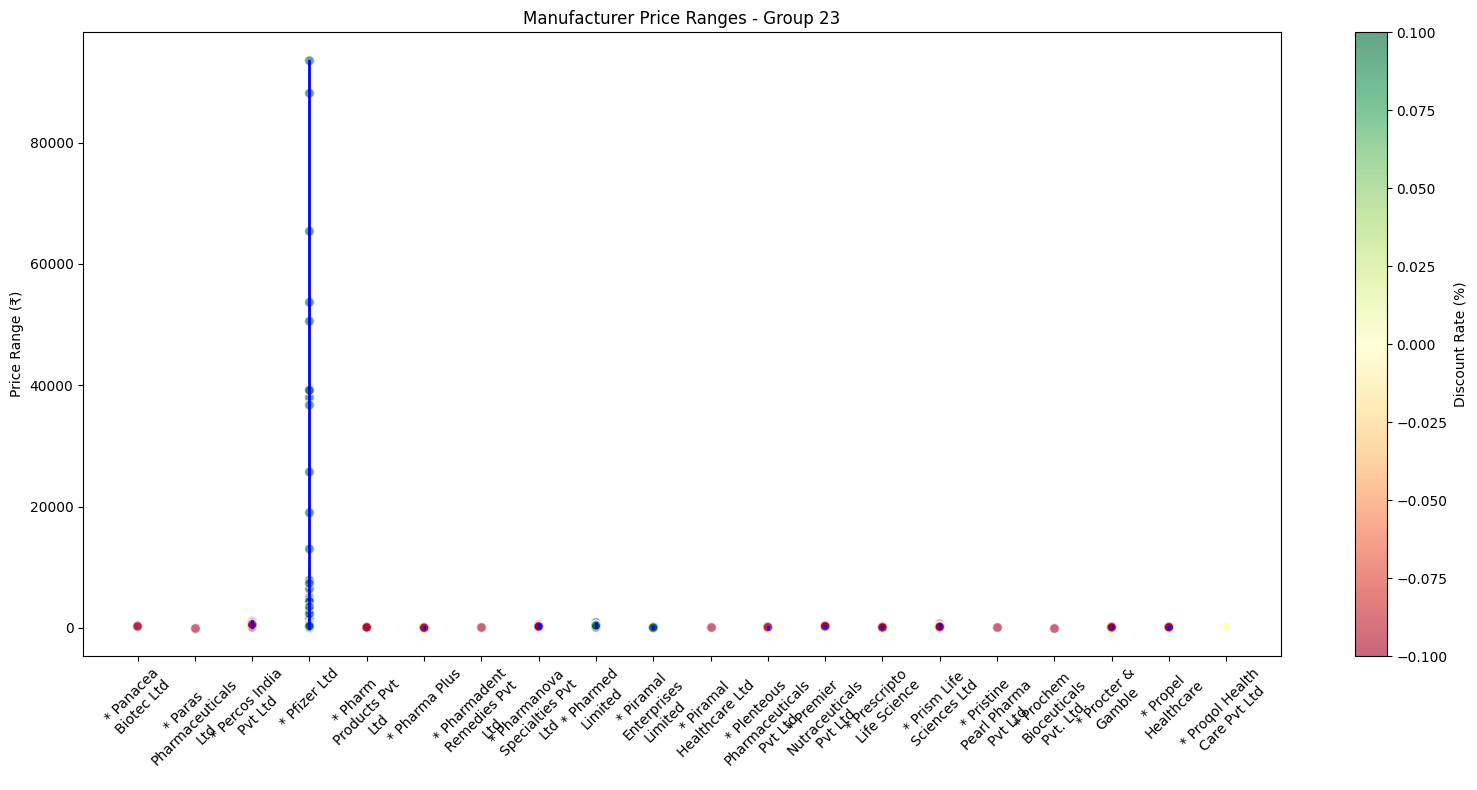

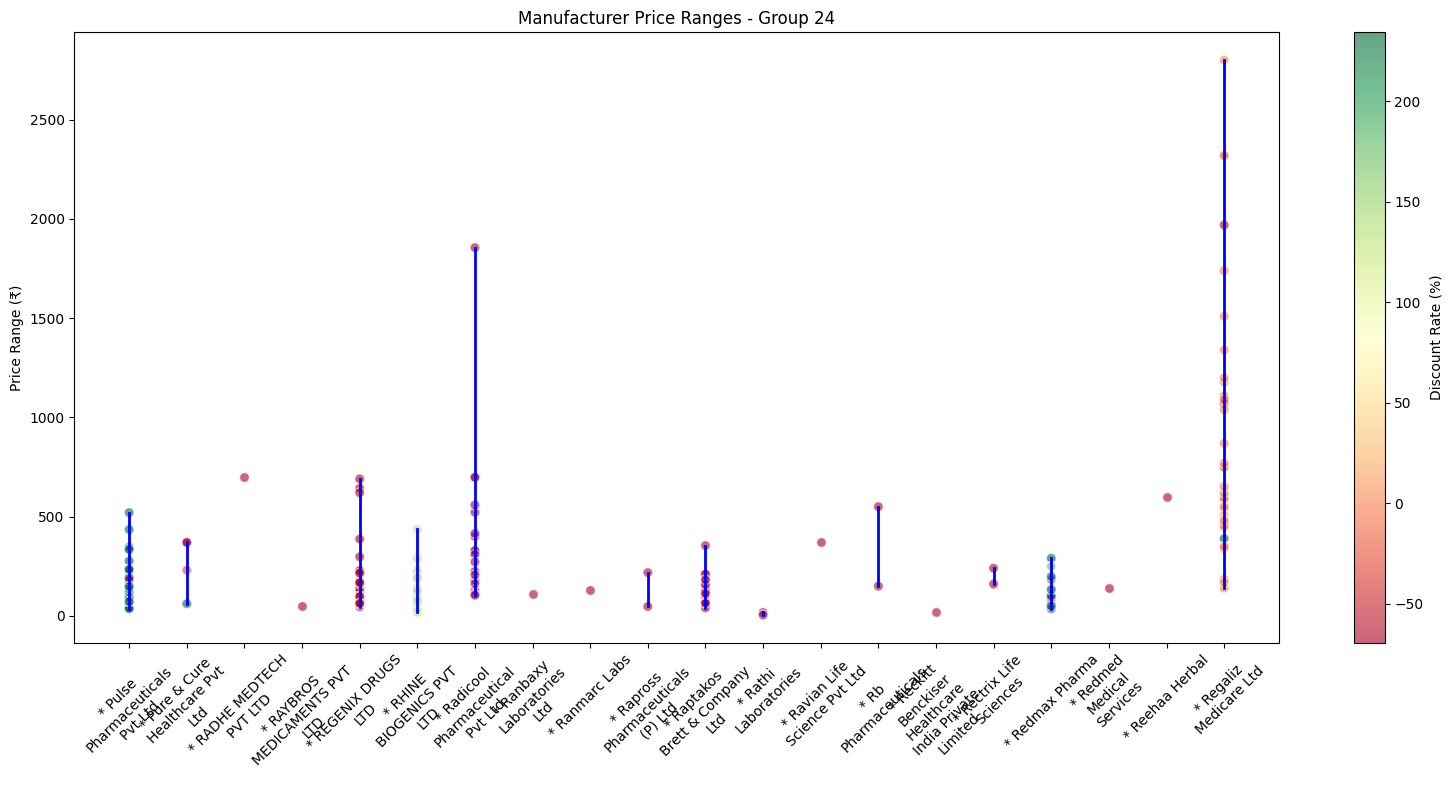

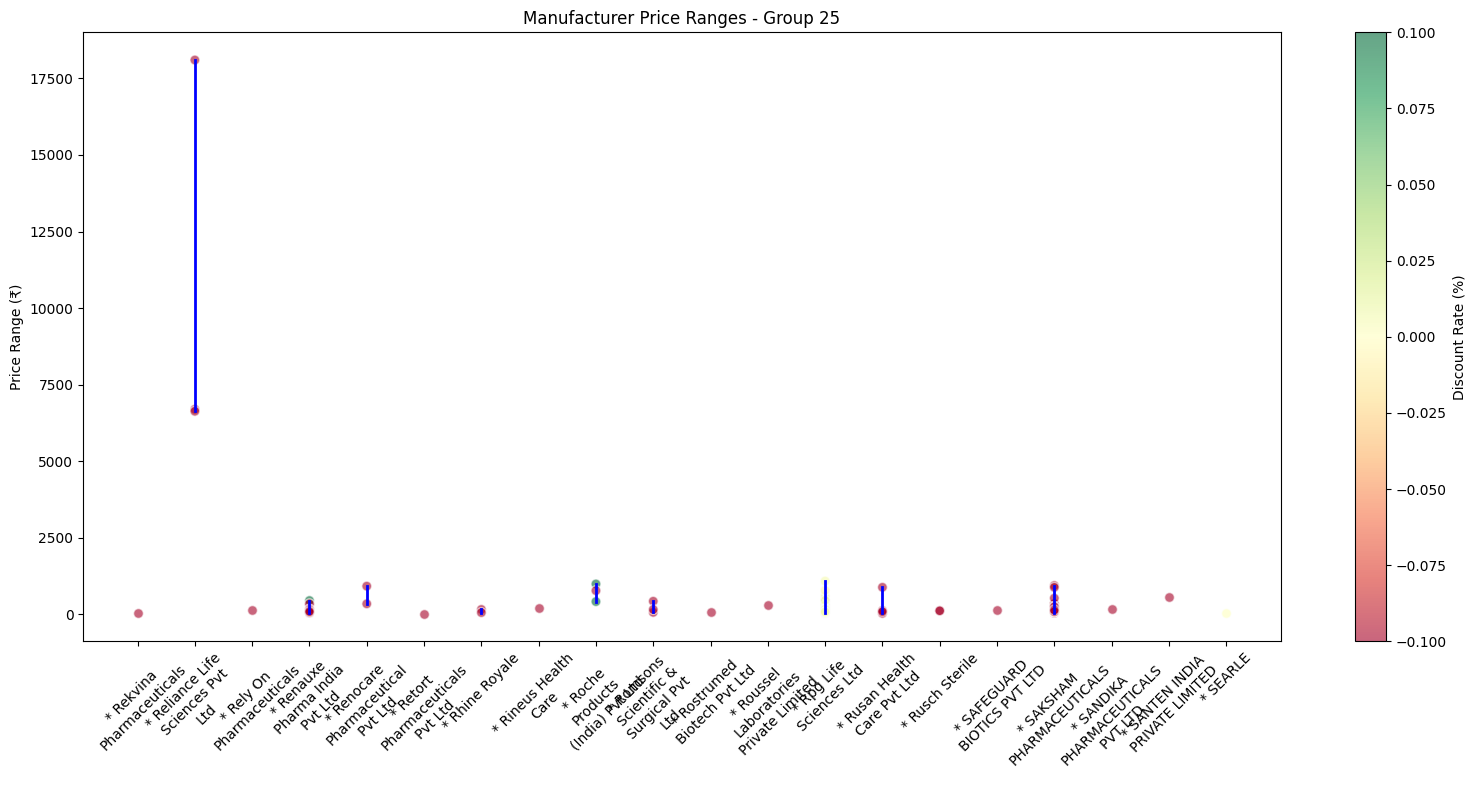

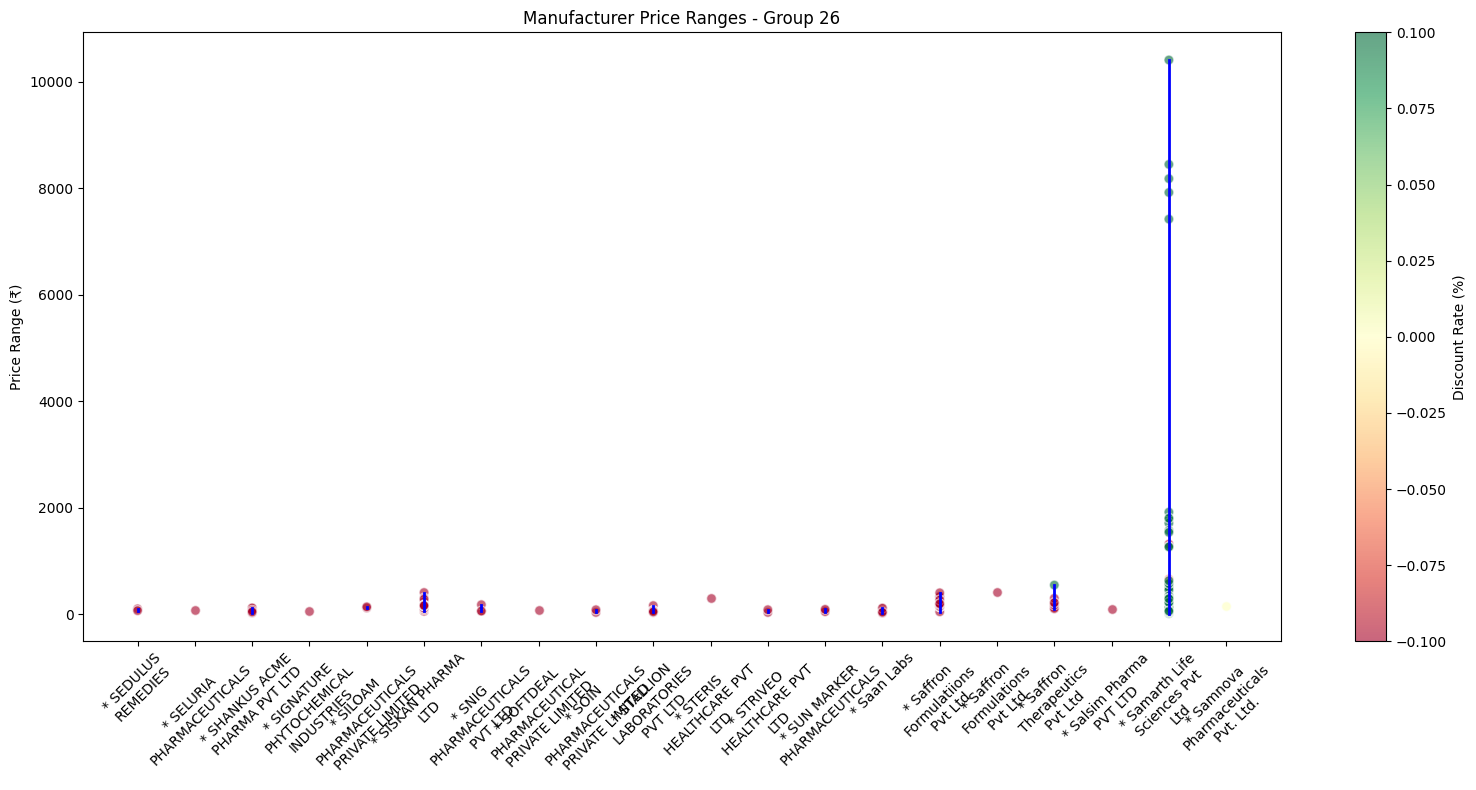

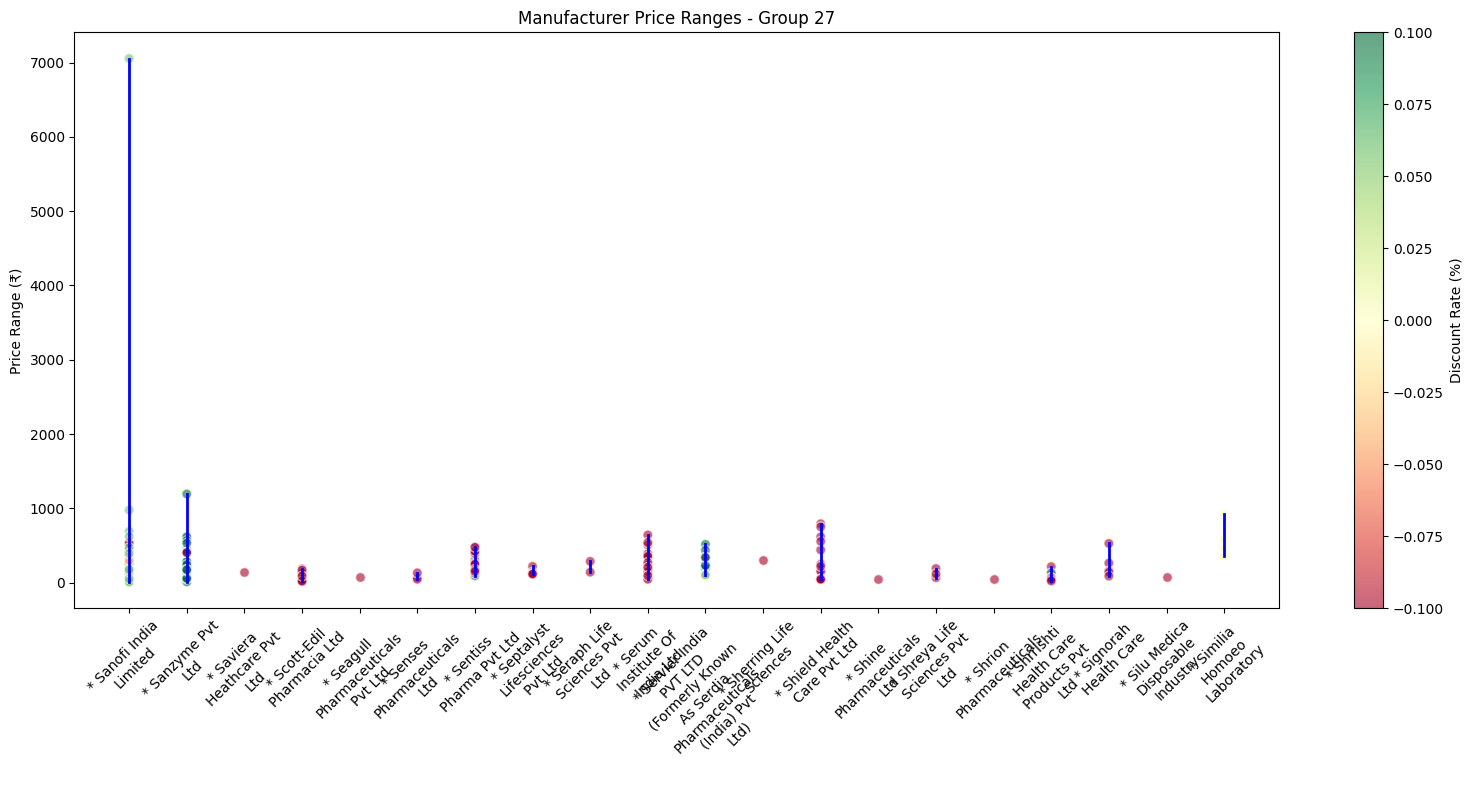

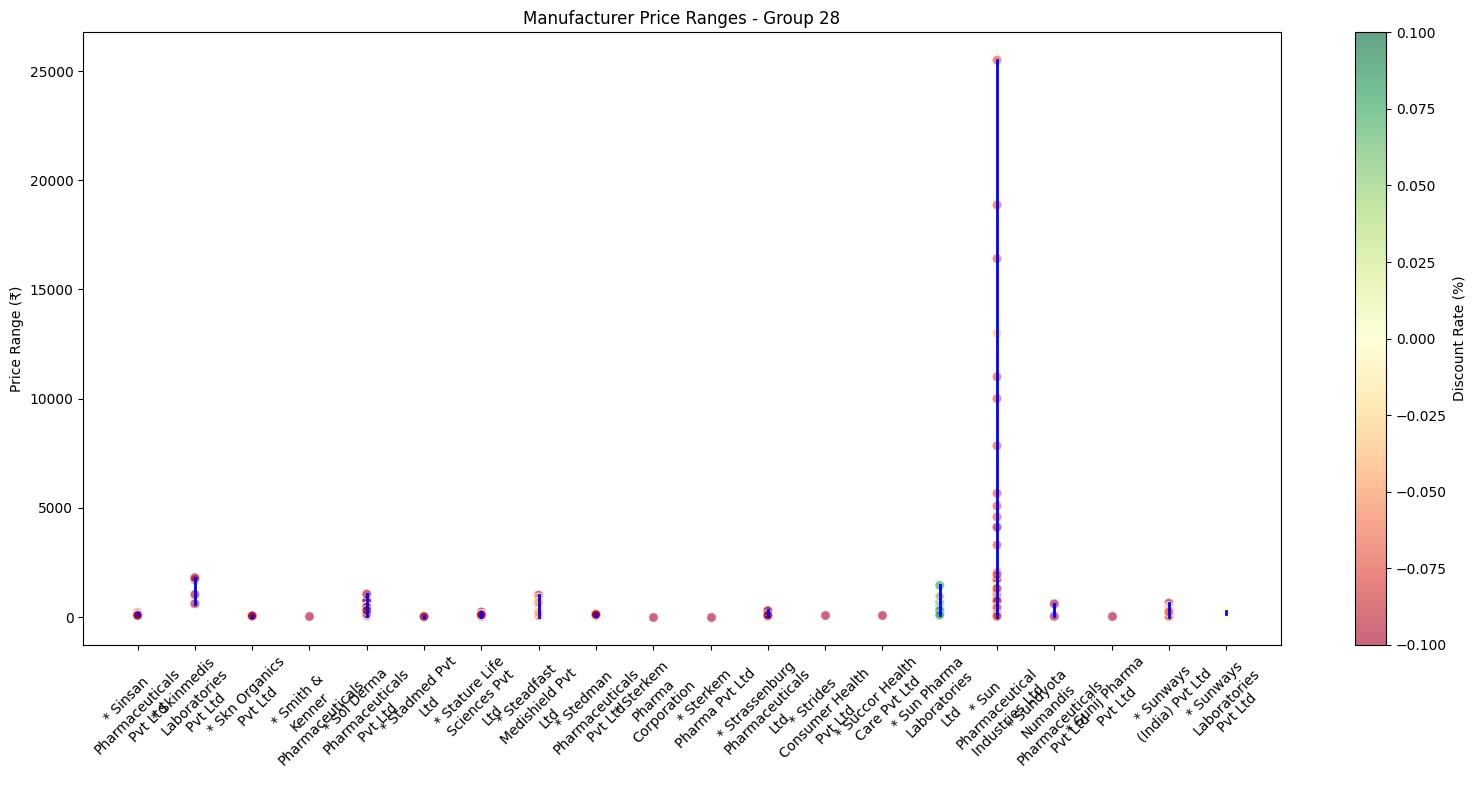

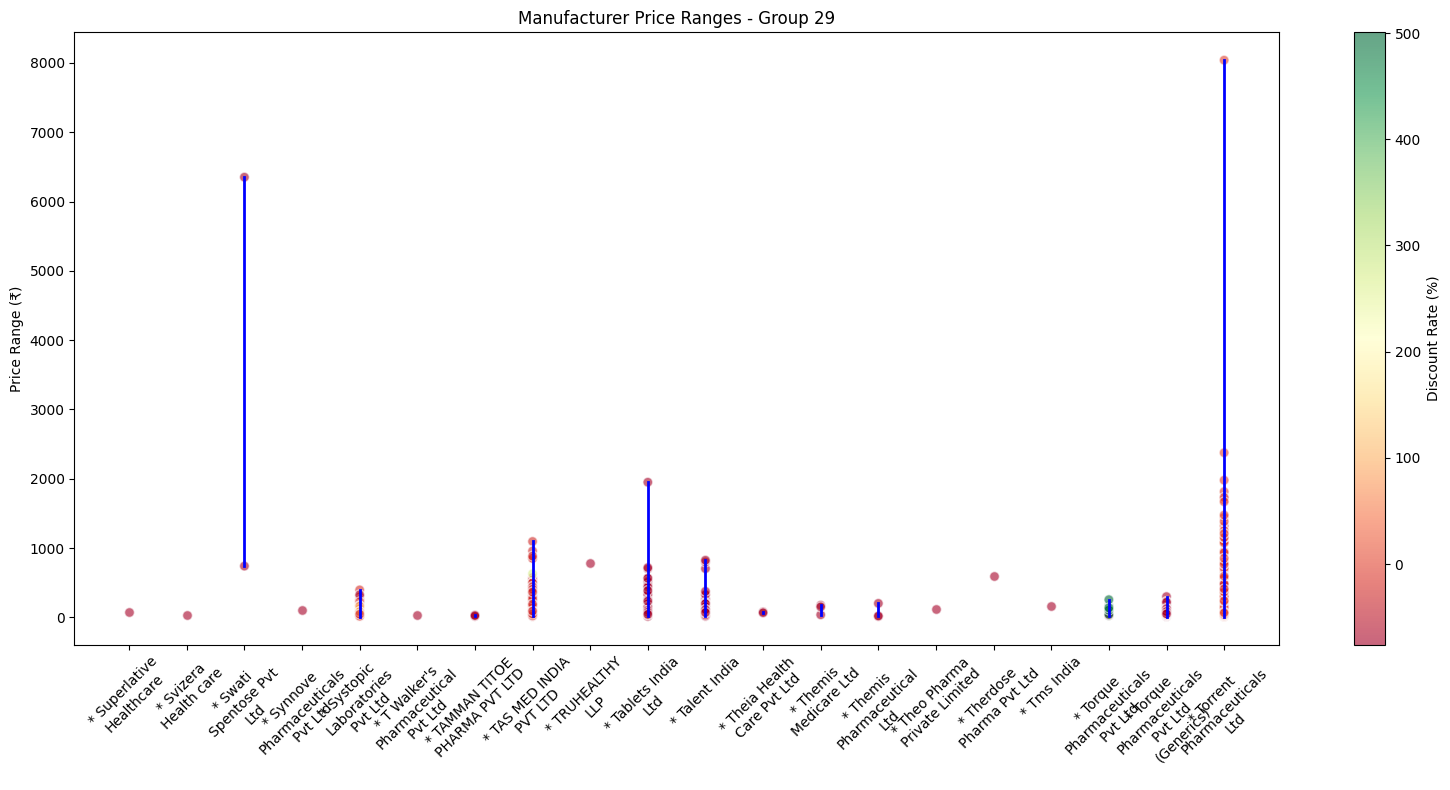

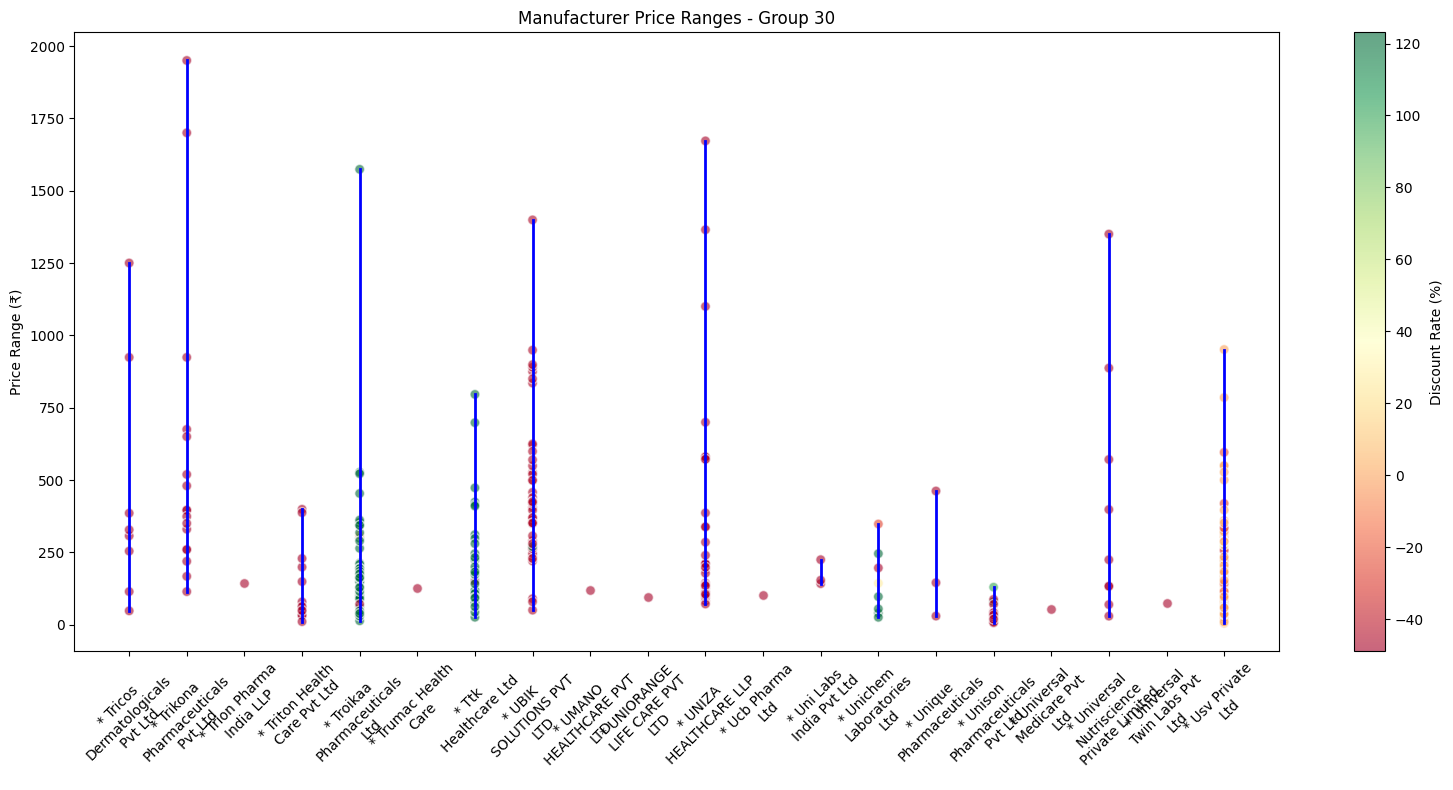

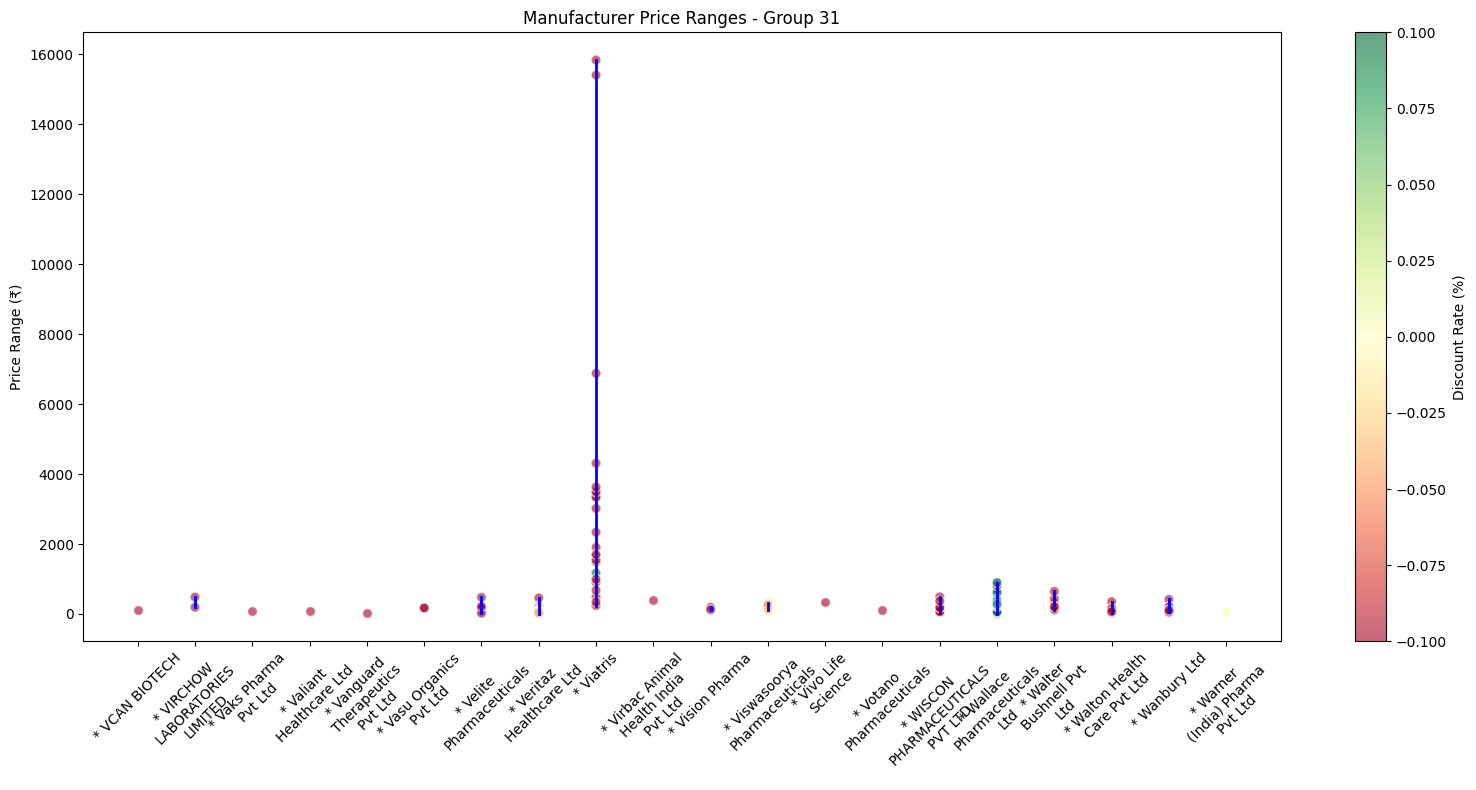

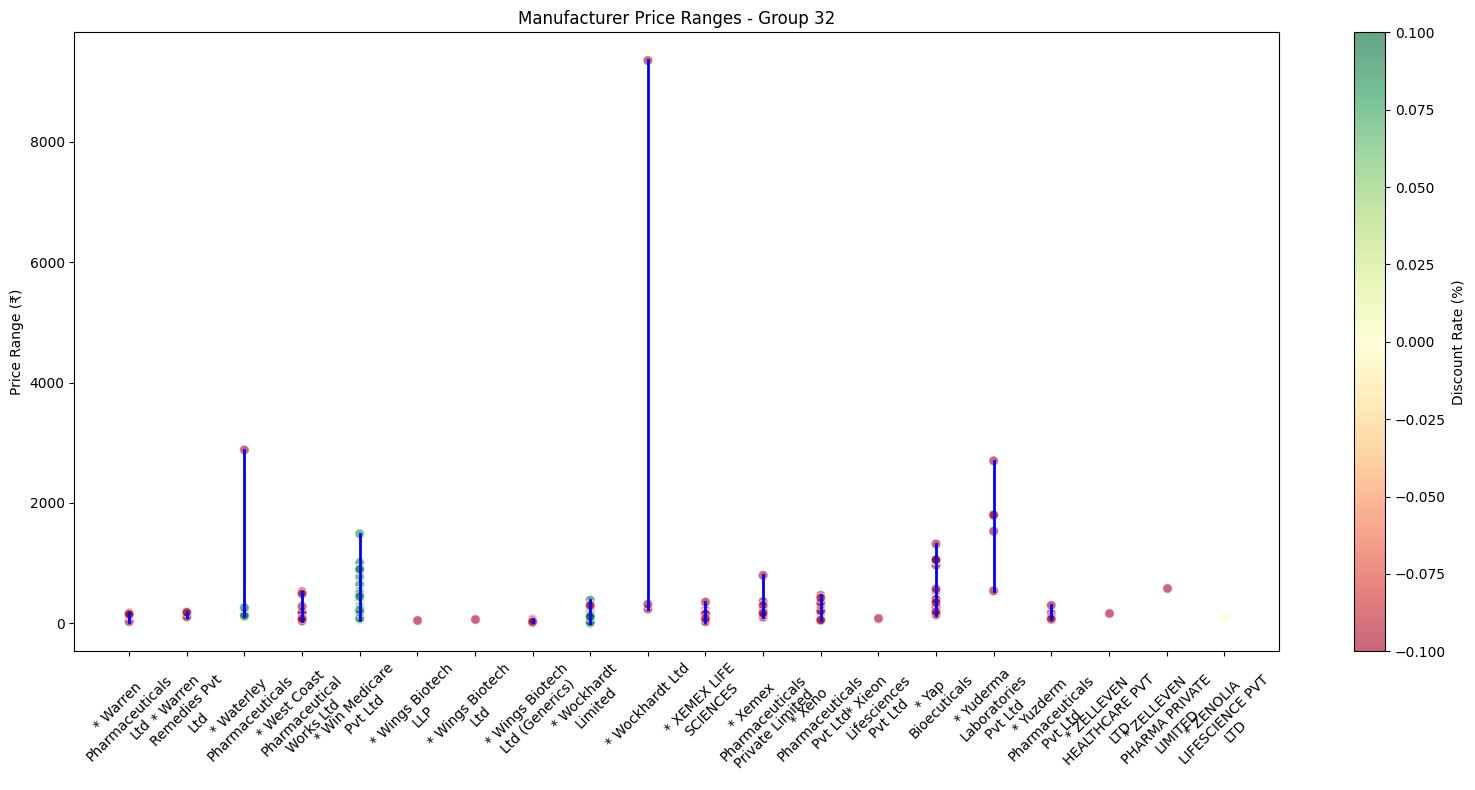

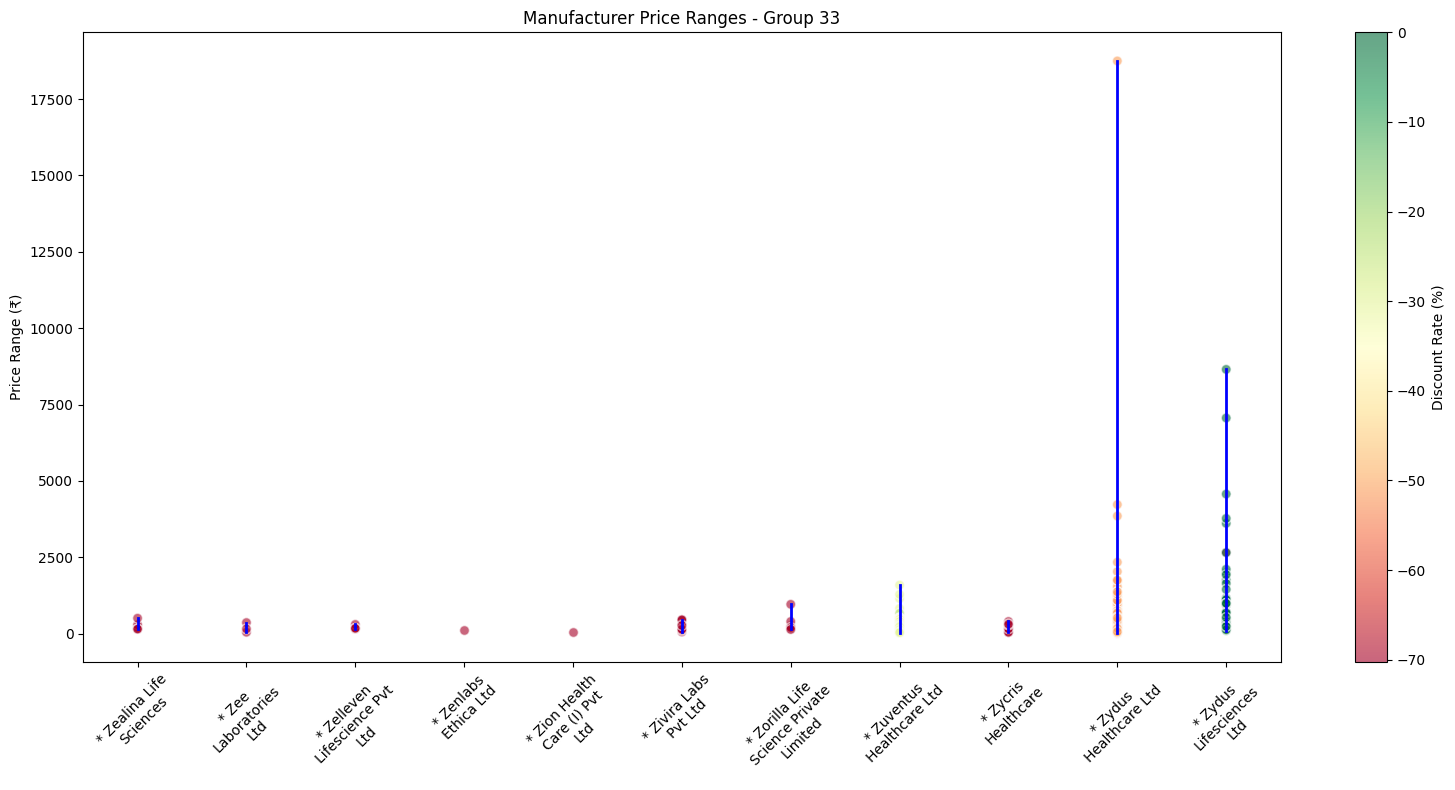

In [7]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from textwrap import wrap

# Handle CSV parsing errors and large files
try:
    df = pd.read_csv('medicines.csv', on_bad_lines='warn', engine='python')
except pd.errors.ParserError:
    df = pd.read_csv('medicines.csv', on_bad_lines='skip', engine='python')

# Process final_price
def extract_final_price(s):
    match = re.search(r'₹(\d+\.?\d*)', str(s))
    return float(match.group(1)) if match else None

df['final_price_value'] = df['final_price'].apply(extract_final_price)

# Process price and discounts
def process_price(row):
    price_str = row['price']
    final_price = row['final_price_value'] or 0

    if pd.isna(price_str) or str(price_str).strip() == '':
        return final_price, 0.0

    patterns = [
        (r'MRP\s*₹\s*(\d+\.?\d*)\s+Save\s+(\d+)%', 'save'),
        (r'MRP\s+Rs\.?\s*(\d+\.?\d*)', 'mrp_rs'),
        (r'MRP\s*₹\s*(\d+\.?\d*)', 'mrp_normal')
    ]

    for pattern, ptype in patterns:
        match = re.match(pattern, str(price_str), re.IGNORECASE)
        if match:
            price = float(match.group(1))
            if ptype == 'save':
                return price, float(match.group(2))
            elif ptype == 'mrp_rs':
                discount = ((price - final_price)/final_price)*100 if final_price else 0
                return price, discount
            else:
                return price, 0.0

    return final_price, 0.0

df[['price_value', 'discount_rate']] = df.apply(process_price, axis=1, result_type='expand')

# Clean manufacturer names
df['manufacturer'] = df['drug_manufacturer'].str.replace('Mkt: ', '', regex=False).str.strip()

# Grouping and visualization parameters
GROUP_SIZE = 20  # Number of categories per plot

def plot_grouped_data(df_grouped, title_prefix, group_type):
    groups = list(df_grouped)
    total_groups = len(groups)

    for i in range(0, total_groups, GROUP_SIZE):
        chunk = groups[i:i+GROUP_SIZE]
        group_names = [name for name, _ in chunk]

        plt.figure(figsize=(16, 8))
        for idx, (name, group) in enumerate(chunk):
            # Calculate statistics
            min_price = group['final_price_value'].min()
            max_price = group['final_price_value'].max()
            avg_discount = group['discount_rate'].mean()

            # Plot range bars
            plt.plot([idx, idx], [min_price, max_price],
                    color='blue', linewidth=2)

            # Plot individual points
            plt.scatter([idx]*len(group), group['final_price_value'],
                      c=group['discount_rate'], cmap='RdYlGn',
                      alpha=0.6, edgecolors='w', s=50)

        # Formatting
        plt.colorbar(label='Discount Rate (%)')
        plt.xticks(range(len(group_names)),
                  ['\n'.join(wrap(name, 15)) for name in group_names],
                  rotation=45)
        plt.ylabel('Price Range (₹)')
        plt.title(f"{title_prefix} - Group {i//GROUP_SIZE + 1}")
        plt.tight_layout()
        plt.show()

# Process diseases
disease_groups = df.sort_values('disease_name').groupby('disease_name')
plot_grouped_data(disease_groups, 'Disease Price Ranges', 'Disease Name')

# Process manufacturers
manufacturer_groups = df.sort_values('manufacturer').groupby('manufacturer')
plot_grouped_data(manufacturer_groups, 'Manufacturer Price Ranges', 'Manufacturer')